# Icclim indices - CSDI (Cold-spell duration index (days))

Assessment of model icclim indices

In [1]:
import glob
import warnings
warnings.filterwarnings('ignore')
import yaml
import logging
logging.basicConfig(level=logging.CRITICAL)

import numpy as np
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import xarray as xr

#import sys
#sys.path.append('/g/data/xv83/users/at2708/bias_adjustment/evaluation/npcp/results')
import utils

In [2]:
outdir = '/g/data/ia39/npcp/code/results/figures/'

In [3]:
def average_index(da):
    """Calculate the average index"""
    
    da_mean = da.mean(dim='time')

    return da_mean

In [4]:
# Data collection and processing
def get_data(gcm, rcm, task, index):
    """Get processed icclim data"""
    
    tasks={
        "historical":{
            "start_date": "19800101",
            "end_date": "20191231",
            "start_date_train": "19800101",
            "end_date_train": "20191231"
        },
        "xvalidation":{
            "start_date": "19900101",
            "end_date": "20191231",
            "start_date_train": "19600101",
            "end_date_train": "19891231"
        },
        "projection":{
            "start_date": "20600101",
            "end_date": "20991231",
            "start_date_train": "19800101",
            "end_date_train": "20191231"
        },
        "agcd_training":{
            "start_date": "19600101",
            "end_date": "19891231",
        }
    }
    assert gcm in ['CSIRO-ACCESS-ESM1-5', 'NCAR-CESM2', 'EC-Earth-Consortium-EC-Earth3']
    assert rcm in ['BOM-BARPA-R', 'CSIRO-CCAM-2203', 'UQ-DES-CCAM-2105']
    assert task in ['historical', 'xvalidation']
    
    da_dict = {}
        
    base_dir = '/g/data/ia39/npcp/data/icclim/'+index+'/'+index+'_NPCP-20i_'

    if gcm=='CSIRO-ACCESS-ESM1-5':
        real='r6i1p1f1'
    elif gcm=='NCAR-CESM2':
        real='r11i1p1f1'
    else:
        real='r1i1p1f1'
    
    if task == 'historical' or task == 'xvalidation':  
        # AGCD
        path = base_dir+'AGCD_v1-0-1_day_'+tasks[task]['start_date']+'-'+tasks[task]['end_date']+'.nc'
        da_dict['agcd'] = xr.open_dataset(path)[index]
        
    if task == 'xvalidation':
        # AGCD training 
        path = base_dir+'AGCD_v1-0-1_day_'+tasks['agcd_training']['start_date']+'-'+tasks['agcd_training']['end_date']+'.nc'
        da_dict['agcd_training'] = xr.open_dataset(path)[index]  
        
    if task == 'projection' or task == 'xvalidation':  
        # QDC GCM 
        path_base = base_dir+gcm+'_ssp370_'+real+'_GCM_v1_day_'+tasks[task]['start_date']+'-'+tasks[task]['end_date']+'_qdc-'
        path = glob.glob(path_base + '*.nc')
        if len(path) == 1:        
            da_dict['gcm_qdc'] = xr.open_dataset(path[0])[index]
        elif len(path) == 0:
            print(f"Warning: GCM_qdc data for {gcm} is missing for the period {tasks[task]['start_date']} to {tasks[task]['end_date']}.")
            da_dict['gcm_qdc'] = None
        else:
            raise OSError(f"Too many GCM_qdc files for {gcm}, {tasks[task]['start_date']} to {tasks[task]['end_date']}.")
            
        # QDC RCMs
        path_base = base_dir+gcm+'_ssp370_'+real+'_'+rcm+'_v1_day_'+tasks[task]['start_date']+'-'+tasks[task]['end_date']+'_qdc-'
        path = glob.glob(path_base + '*.nc')
        if len(path) == 1:
            da_dict['rcm_qdc'] = xr.open_dataset(path[0])[index]
        elif len(path) == 0:
            print(f"Warning: RCM_qdc data for {gcm}/{rcm} is missing for the period period {tasks[task]['start_date']} to {tasks[task]['end_date']}.")
            da_dict['rcm_qdc'] = None
        else:
            raise OSError(f"Too many RCM_qdc files for {gcm}/{rcm}, {tasks[task]['start_date']} to {tasks[task]['end_date']}.")

    # GCM raw
    try:
        path = base_dir+gcm+'_ssp370_'+real+'_GCM_latest_day_'+tasks[task]['start_date']+'-'+tasks[task]['end_date']+'.nc'
        da_dict['gcm_raw'] = xr.open_dataset(path)[index]
    except OSError:
        print(f"Warning: GCM_raw data for {gcm} is missing for the period period {tasks[task]['start_date']} to {tasks[task]['end_date']}.")
        da_dict['gcm_raw'] = None
        
    # RCM raw
    try:
        path = base_dir+gcm+'_ssp370_'+real+'_'+rcm+'_v1_day_'+tasks[task]['start_date']+'-'+tasks[task]['end_date']+'.nc'
        da_dict['rcm_raw'] = xr.open_dataset(path)[index]
    except OSError:
        print(f"Warning: RCM_raw data for {gcm}/{rcm} is missing for the period period {tasks[task]['start_date']} to {tasks[task]['end_date']}.")
        da_dict['rcm_raw'] = None
    
    # ECDFM GCM 
    path_base=base_dir+gcm+'_ssp370_'+real+'_GCM_v1_day_'+tasks[task]['start_date']+'-'+tasks[task]['end_date']+'_ecdfm-'
    path = glob.glob(path_base + '*.nc')
    if len(path) == 1:
        da_dict['gcm_ecdfm'] = xr.open_dataset(path[0])[index]
    elif len(path) == 0:
        print(f"Warning: GCM_ecdfm data for {gcm} is missing for the period period {tasks[task]['start_date']} to {tasks[task]['end_date']}.")
        da_dict['gcm_ecdfm'] = None
    else:
        raise OSError(f"Too many GCM_ecdfm files for {gcm}/{rcm}, {tasks[task]['start_date']} to {tasks[task]['end_date']}.")
        
    # ECDFM RCMs
    path_base=base_dir+gcm+'_ssp370_'+real+'_'+rcm+'_v1_day_'+tasks[task]['start_date']+'-'+tasks[task]['end_date']+'_ecdfm-'
    path = glob.glob(path_base + '*.nc')
    if len(path) == 1:
        da_dict['rcm_ecdfm'] = xr.open_dataset(path[0])[index]
    elif len(path) == 0:
        print(f"Warning: RCM_ecdfm data for {gcm}/{rcm} is missing for the period period {tasks[task]['start_date']} to {tasks[task]['end_date']}.")
        da_dict['rcm_ecdfm'] = None
    else:
        raise OSError(f"Too many RCM_ecdfm files for {gcm}/{rcm}, {tasks[task]['start_date']} to {tasks[task]['end_date']}.")
        
    # QME RCMs
    try:
        path = base_dir+gcm+'_ssp370_'+real+'_'+rcm+'_v1_day_'+tasks[task]['start_date']+'-'+tasks[task]['end_date']+'_qme-AGCD-'+tasks[task]['start_date_train']+'-'+tasks[task]['end_date_train']+'.nc'
        da_dict['rcm_qme'] = xr.open_dataset(path)[index]
        lats = np.round(np.arange(-44, -9.9, 0.2), decimals=1)
        if np.allclose(da_dict['rcm_qme']['lat'].values, lats, rtol=1e-05, atol=1e-08, equal_nan=True):
            lat_attrs = da_dict['rcm_qme']['lat'].attrs
            da_dict['rcm_qme'] = da_dict['rcm_qme'].assign_coords({'lat': lats})
            da_dict['rcm_qme'].attrs = lat_attrs
        lons = np.round(np.arange(112, 154.01, 0.2), decimals=1)
        if np.allclose(da_dict['rcm_qme']['lon'].values, lons, rtol=1e-05, atol=1e-08, equal_nan=True):
            lon_attrs = da_dict['rcm_qme']['lon'].attrs
            da_dict['rcm_qme'] = da_dict['rcm_qme'].assign_coords({'lon': lons})
            da_dict['rcm_qme'].attrs = lon_attrs
    except OSError:
        print(f"Warning: RCM_qme data for {gcm}/{rcm} is missing for the period period {tasks[task]['start_date']} to {tasks[task]['end_date']}.")
        da_dict['rcm_qme'] = None  
        
    # MBCN RCMs
    path_base=base_dir+gcm+'_ssp370_'+real+'_'+rcm+'_v1_day_'+tasks[task]['start_date']+'-'+tasks[task]['end_date']+'_mbcn-'
    try:
        path = path_base+'AGCD-'+tasks[task]['start_date_train']+'-'+tasks[task]['end_date_train']+'.nc'
        da_dict['rcm_mbcn'] = xr.open_dataset(path)[index]
    except OSError:
        print(f"Warning: RCM_mbcn data for {gcm}/{rcm} is missing for the period period {tasks[task]['start_date']} to {tasks[task]['end_date']}.")
        da_dict['rcm_mbcn'] = None    
    
    # MRNBC RCMs
    path_base=base_dir+gcm+'_ssp370_'+real+'_'+rcm+'_v1_day_'+tasks[task]['start_date']+'-'+tasks[task]['end_date']+'_mrnbc-'
    try:
        path = path_base+'AGCD-'+tasks[task]['start_date_train']+'-'+tasks[task]['end_date_train']+'.nc'
        da_dict['rcm_mrnbc'] = xr.open_dataset(path)[index]
    except OSError:
        print(f"Warning: RCM_mrnbc data for {gcm}/{rcm} is missing for the period period {tasks[task]['start_date']} to {tasks[task]['end_date']}.")
        da_dict['rcm_mrnbc'] = None    
        
    return da_dict

In [5]:
# Plotting values
def plot_metric(ax, da, cmap, levels, index, model_name, ob_fractions=None):
    """Plot the PT index for a particular model"""
    data = average_index(da)
    data = utils.clip_data(data, utils.get_aus_shape())
    if ob_fractions is not None:
        data = utils.mask_by_pr_ob_fraction(data, ob_fractions, threshold=0.9)    

    data.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend='both',
        cbar_kwargs={'label': index},
    )
    ax.set_title(model_name)
    ax.coastlines()


def plot_values(gcm, rcm, task, index, cmap, levels, outfile=None):
    
    da_dict = get_data(gcm, rcm, task, index)

    """Plot the index for each model/method"""

    ncols = 5 if task == 'xvalidation' else 4
    nrows = 3
    plot_nums = np.arange(1, (ncols * nrows) + 1)
    
    if index=='R10mm' or index=='R20mm' or index=='R95pTOT' or index=='R99pTOT':
        ob_fractions = utils.get_pr_weights(gcm, task)
    else:
        ob_fractions = None
    
    fig = plt.figure(figsize=[7 * ncols, 5 * nrows])
    
    # GCM bias indexection
    plot_index = 0
    if da_dict['gcm_raw'] is not None:
        ax_gcm1 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_metric(
            ax_gcm1, da_dict['gcm_raw'], cmap, levels, index, gcm, ob_fractions=ob_fractions,
        )
    plot_index = plot_index + 1

    if da_dict['gcm_ecdfm'] is not None:
        ax_gcm2 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_metric(
            ax_gcm2,  da_dict['gcm_ecdfm'], cmap, levels, index, f'{gcm} (ecdfm)', ob_fractions=ob_fractions,
        )
    
    plot_index = plot_index + 1   # blank space

    if task == 'xvalidation':
        plot_index = plot_index + 1
        if da_dict['gcm_qdc'] is not None:
            ax_gcm4 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
            plot_metric(
                ax_gcm4, da_dict['gcm_qdc'],  cmap, levels, index, f'{gcm} (qdc)', ob_fractions=ob_fractions,
            )

    plot_index = plot_index + 1
    ax_obs = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_metric(ax_obs, da_dict['agcd'], cmap, levels, index, 'AGCD', ob_fractions=ob_fractions)
        
    # RCM bias indexection
    plot_index = plot_index + 1
    if da_dict['rcm_raw'] is not None:
        ax_rcm1 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_metric(
            ax_rcm1, da_dict['rcm_raw'], cmap, levels, index, f'{rcm} (raw)', ob_fractions=ob_fractions,
        )
    
    plot_index = plot_index + 1

    if da_dict['rcm_ecdfm'] is not None:
        ax_rcm2 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_metric(
            ax_rcm2, da_dict['rcm_ecdfm'], cmap, levels, index, f'{rcm} (ecdfm)', ob_fractions=ob_fractions,
        )
    
    plot_index = plot_index + 1

    if da_dict['rcm_qme'] is not None:
        ax_rcm3 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_metric(
            ax_rcm3, da_dict['rcm_qme'], cmap, levels, index, f'{rcm} (qme)', ob_fractions=ob_fractions,
        )
    if task == 'xvalidation':
        plot_index = plot_index + 1
        if da_dict['rcm_qdc'] is not None:
            ax_rcm4 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
            plot_metric(
                ax_rcm4, da_dict['rcm_qdc'], cmap, levels, index, f'{rcm} (qdc)', ob_fractions=ob_fractions,
            )

        plot_index = plot_index + 1
        ax_rcm5 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_metric(
            ax_rcm5, da_dict['agcd_training'], cmap, levels, index, f'AGCD (training data)', ob_fractions=ob_fractions,
        )
        plot_index = plot_index - 1
    # RCM multivariate bias correction
    plot_index = plot_index + 2 
    
    plot_index = plot_index + 1
    if da_dict['rcm_mbcn'] is not None:
        ax_rcm6 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_metric(
            ax_rcm6, da_dict['rcm_mbcn'], cmap, levels, index, f'{rcm} (mbcn)', ob_fractions=ob_fractions,
        )
    
    plot_index = plot_index + 1

    if da_dict['rcm_mrnbc'] is not None:
        ax_rcm7 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_metric(
            ax_rcm7, da_dict['rcm_mrnbc'], cmap, levels, index, f'{rcm} (mrnbc)', ob_fractions=ob_fractions,
        )

    if gcm == 'ECMWF-ERA5':
        start_year = '2000' if task == 'xvalidation' else '1980'
    else:
        start_year = '1990' if task == 'xvalidation' else '1980'
    
    plt.suptitle(f'Annual mean {start_year}-2019 '+index, fontsize='x-large')
    if outfile:
        figpath = f'{index}-values_task-{task}_{gcm}_{rcm}.png'
        print(figpath)
        plt.savefig(figpath, dpi=300, bbox_inches='tight')
    plt.show()

In [6]:
# Plotting bias
def plot_bias(ax, da_obs, da_model, cmap, levels, index, model_name, ob_fractions=None):
    """Plot the bias for a particular model"""

    index_model = average_index(da_model)
    index_obs = average_index(da_obs)
    
    bias = index_model - index_obs
    bias = utils.clip_data(bias, utils.get_aus_shape())
    if ob_fractions is not None:
        bias = utils.mask_by_pr_ob_fraction(bias, ob_fractions, threshold=0.9)    
    mae = float(np.nanmean(np.abs(bias)))

    bias.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend='both',
        cbar_kwargs={'label': index},
    )
    ax.text(0.02, 0.02, f'MAE: {mae:.2f}', transform=ax.transAxes, fontsize='large')
    ax.set_title(model_name)
    ax.coastlines()
    
    return mae


def plot_comparison(gcm, rcm, task, index, cmap, levels, outfile=None):
    """Plot the complete comparison"""

    da_dict = get_data(gcm, rcm, task, index)

    ncols = 5 if task == 'xvalidation' else 3
    nrows = 3
    plot_nums = np.arange(1, (ncols * nrows) + 1)
    
    if index=='R10mm' or index=='R20mm' or index=='R95pTOT' or index=='R99pTOT':
        ob_fractions = utils.get_pr_weights(gcm, task)
    else:
        ob_fractions = None

    mae_dict = {}
    fig = plt.figure(figsize=[7 * ncols, 5 * nrows])
    
    # GCM bias correction
    plot_index = 0
    if da_dict['gcm_raw'] is not None:
        ax_gcm1 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        mae_dict['GCM'] = plot_bias(
            ax_gcm1, da_dict['agcd'], da_dict['gcm_raw'], cmap, levels, index, f'{gcm} (raw)', ob_fractions=ob_fractions,
        )
    plot_index = plot_index + 1

    if da_dict['gcm_ecdfm'] is not None:
        ax_gcm2 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        mae = plot_bias(
            ax_gcm2, da_dict['agcd'], da_dict['gcm_ecdfm'], cmap, levels, index, f'{gcm} (ECDFm)', ob_fractions=ob_fractions,
        )
    
    plot_index = plot_index + 1   # blank space

    if task == 'xvalidation':
        plot_index = plot_index + 1
        if da_dict['gcm_qdc'] is not None:
            ax_gcm4 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
            mae = plot_bias(
                ax_gcm4, da_dict['agcd'],da_dict['gcm_qdc'], cmap, levels, index, f'{gcm} (QDC)', ob_fractions=ob_fractions,
            )
        plot_index = plot_index + 1
    plot_index = plot_index + 1

    # RCM bias correction
    if da_dict['rcm_raw'] is not None:
        ax_rcm1 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        mae_dict['RCM'] = plot_bias(
            ax_rcm1, da_dict['agcd'],  da_dict['rcm_raw'], cmap, levels, index, f'{rcm} (raw)', ob_fractions=ob_fractions,
        )
    
    plot_index = plot_index + 1
    if da_dict['rcm_ecdfm'] is not None:
        ax_rcm2 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        mae_dict['ECDFm'] = plot_bias(
            ax_rcm2, da_dict['agcd'], da_dict['rcm_ecdfm'], cmap, levels, index, f'{rcm} (ECDFm)', ob_fractions=ob_fractions,
        )
        
    plot_index = plot_index + 1
    if da_dict['rcm_qme'] is not None:
        ax_rcm3 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        mae_dict['QME'] = plot_bias(
            ax_rcm3, da_dict['agcd'], da_dict['rcm_qme'], cmap, levels, index, f'{rcm} (QME)', ob_fractions=ob_fractions,
        )
    plot_index = plot_index + 1
    if task == 'xvalidation':
        # plot_index = plot_index + 1
        if da_dict['rcm_qdc'] is not None:
            ax_rcm4 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
            mae_dict['QDC'] = plot_bias(
                ax_rcm4, da_dict['agcd'], da_dict['rcm_qdc'], cmap, levels, index, f'{rcm} (QDC)', ob_fractions=ob_fractions,
            )
        
        plot_index = plot_index + 1
        ax_rcm5 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        mae_dict['training'] = plot_bias(
            ax_rcm5, da_dict['agcd'], da_dict['agcd_training'], cmap, levels, index, f'AGCD (training data)', ob_fractions=ob_fractions,
        )
        plot_index = plot_index + 1 
        
    # RCM multivariate bias correction
    plot_index = plot_index + 1
    if da_dict['rcm_mbcn'] is not None:
        ax_rcm6 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        mae_dict['MBCn'] = plot_bias(
            ax_rcm6, da_dict['agcd'], da_dict['rcm_mbcn'], cmap, levels, index, f'{rcm} (MBCn)', ob_fractions=ob_fractions,
        )
    
    plot_index = plot_index + 1
    if da_dict['rcm_mrnbc'] is not None:
        ax_rcm7 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        mae_dict['MRNBC'] = plot_bias(
            ax_rcm7, da_dict['agcd'], da_dict['rcm_mrnbc'], cmap, levels, index, f'{rcm} (MRNBC)', ob_fractions=ob_fractions,
        )

    if gcm == 'ECMWF-ERA5':
        start_year = '2000' if task == 'xvalidation' else '1980'
    else:
        start_year = '1990' if task == 'xvalidation' else '1980'
    
    plt.suptitle(f'Bias (model minus obs) in the {start_year}-2019 '+index, fontsize='x-large')
    if outfile:
        figpath = f'{outdir}{index}-bias_task-{task}_{gcm}_{rcm}.png'
        print(figpath)
        plt.savefig(figpath, dpi=300, bbox_inches='tight')
    plt.show()
    
    return mae_dict

In [7]:
mae_data = {}

## task-historical

Bias corrected data for the 1980-2019 period, using 1980-2019 as a training period.

In [8]:
task = 'historical'
mae_data[task] = {}

#### ERA5

In [9]:
#gcm = 'ECMWF-ERA5'
#task = 'historical'
# index = 'CSDI'

In [10]:
#rcm = 'BOM-BARPA-R'
# plot_values()
# plot_comparison()

In [11]:
#rcm = 'CSIRO-CCAM-2203'
# plot_values()
# plot_comparison()

In [12]:
#rcm = 'UQ-DES-CCAM-2105'
# plot_values()
# plot_comparison()

#### ACCESS-ESM1-5

In [9]:
gcm = 'CSIRO-ACCESS-ESM1-5'
task = 'historical'
index = 'CSDI'
levels_values = [1, 2, 3, 4, 5, 6]
cmap_values = 'Blues'
levels_bias = [-5,-4,-3,-2,-1,1,2,3,4,5]
cmap_bias = 'RdBu_r'
outfile = False

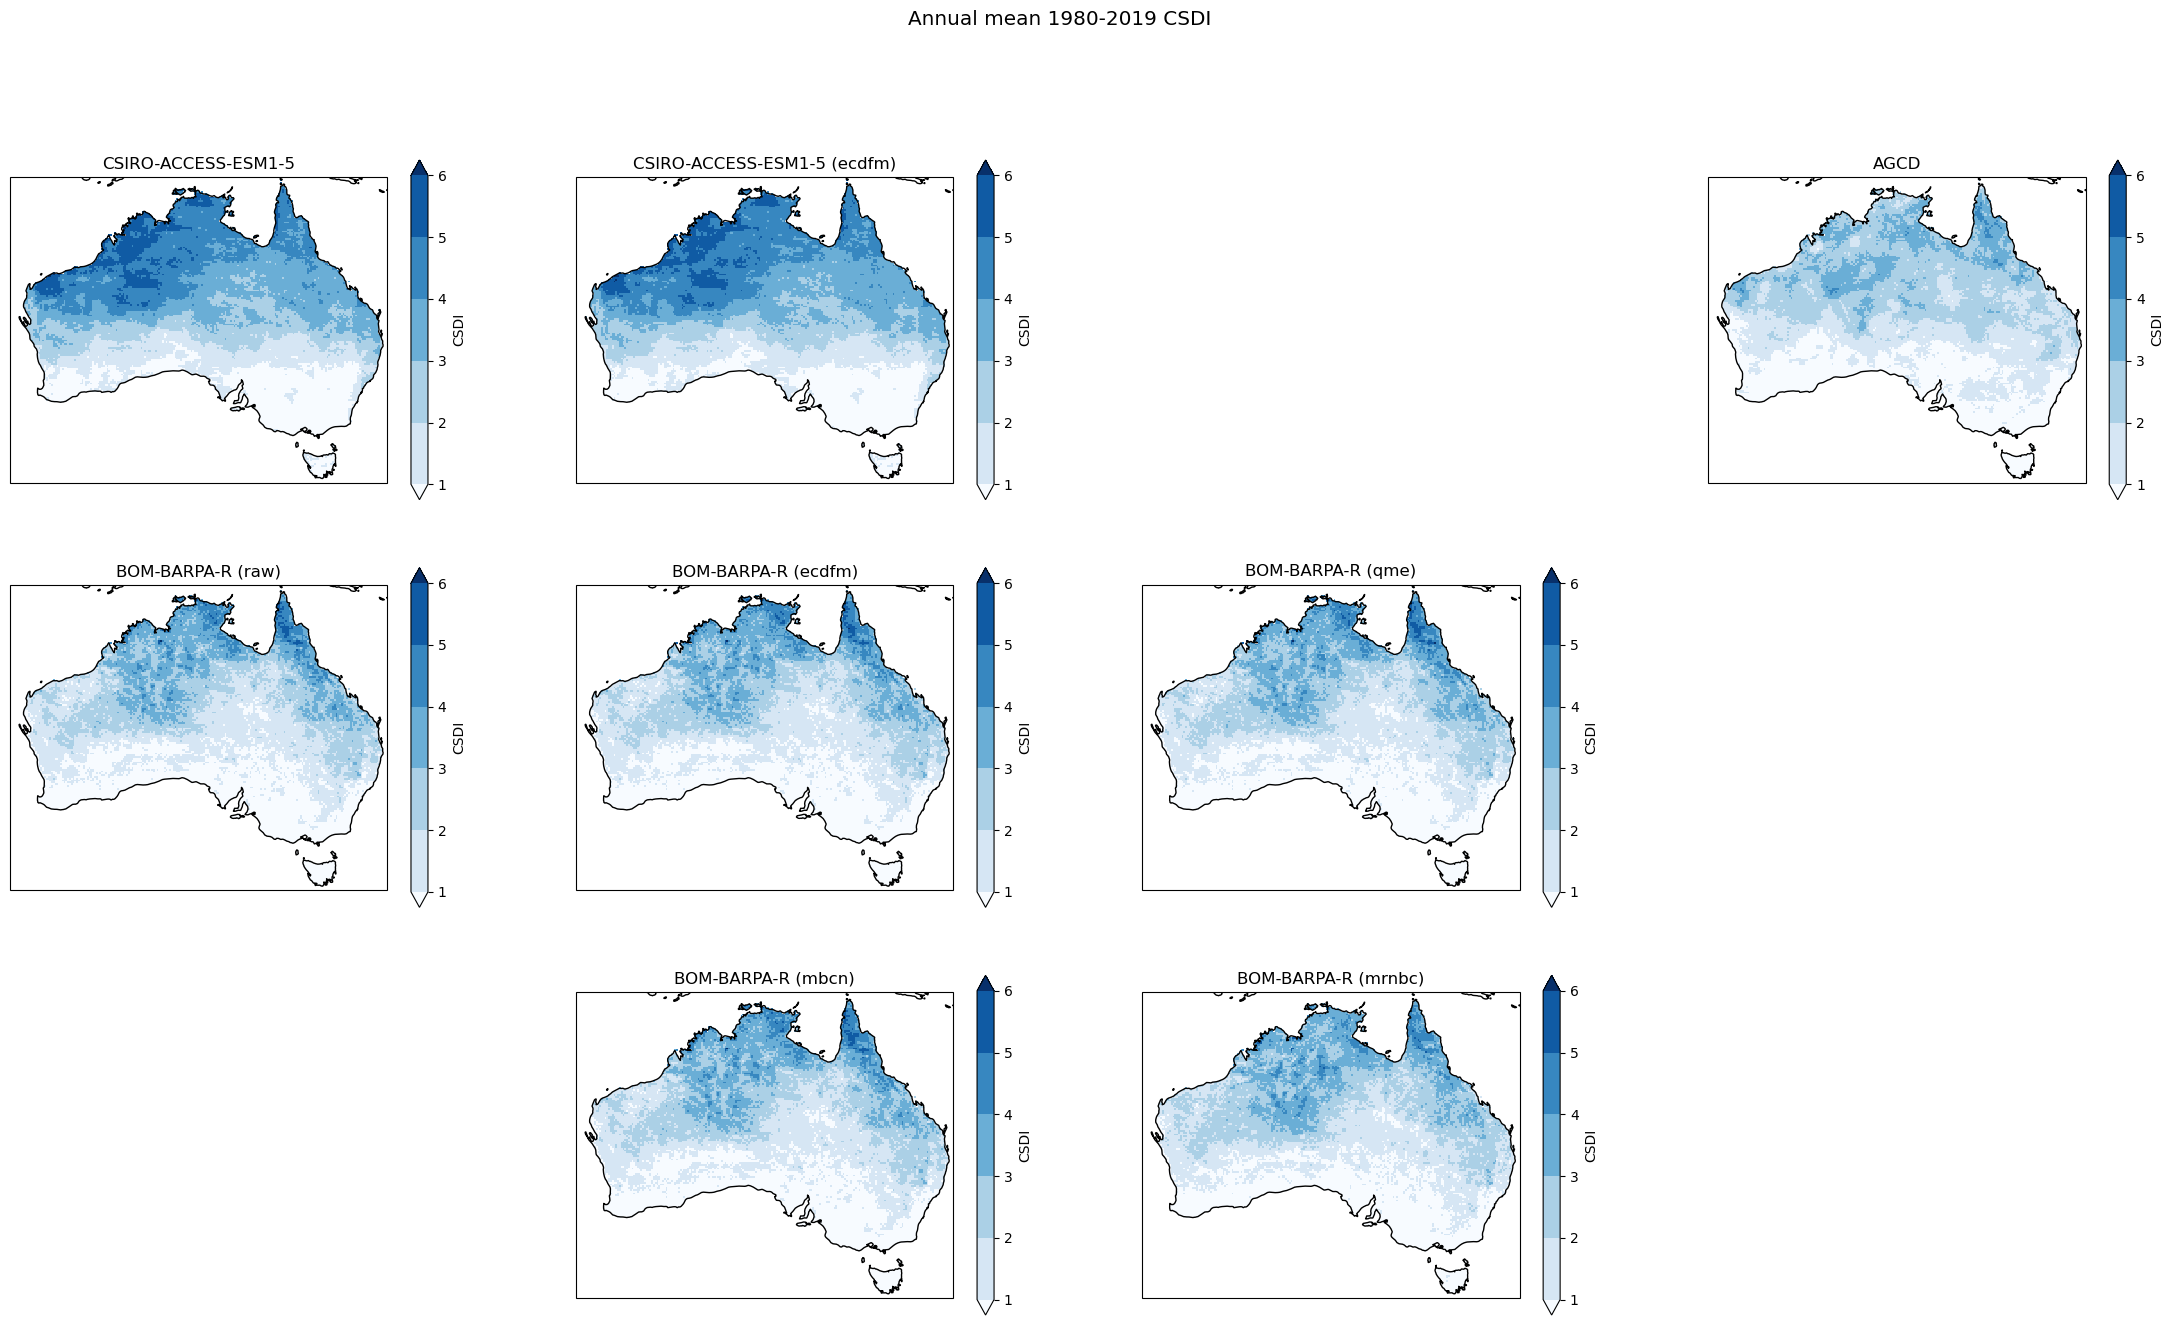

In [14]:
rcm = 'BOM-BARPA-R'
plot_values(gcm, rcm, task, index, cmap=cmap_values, levels=levels_values)

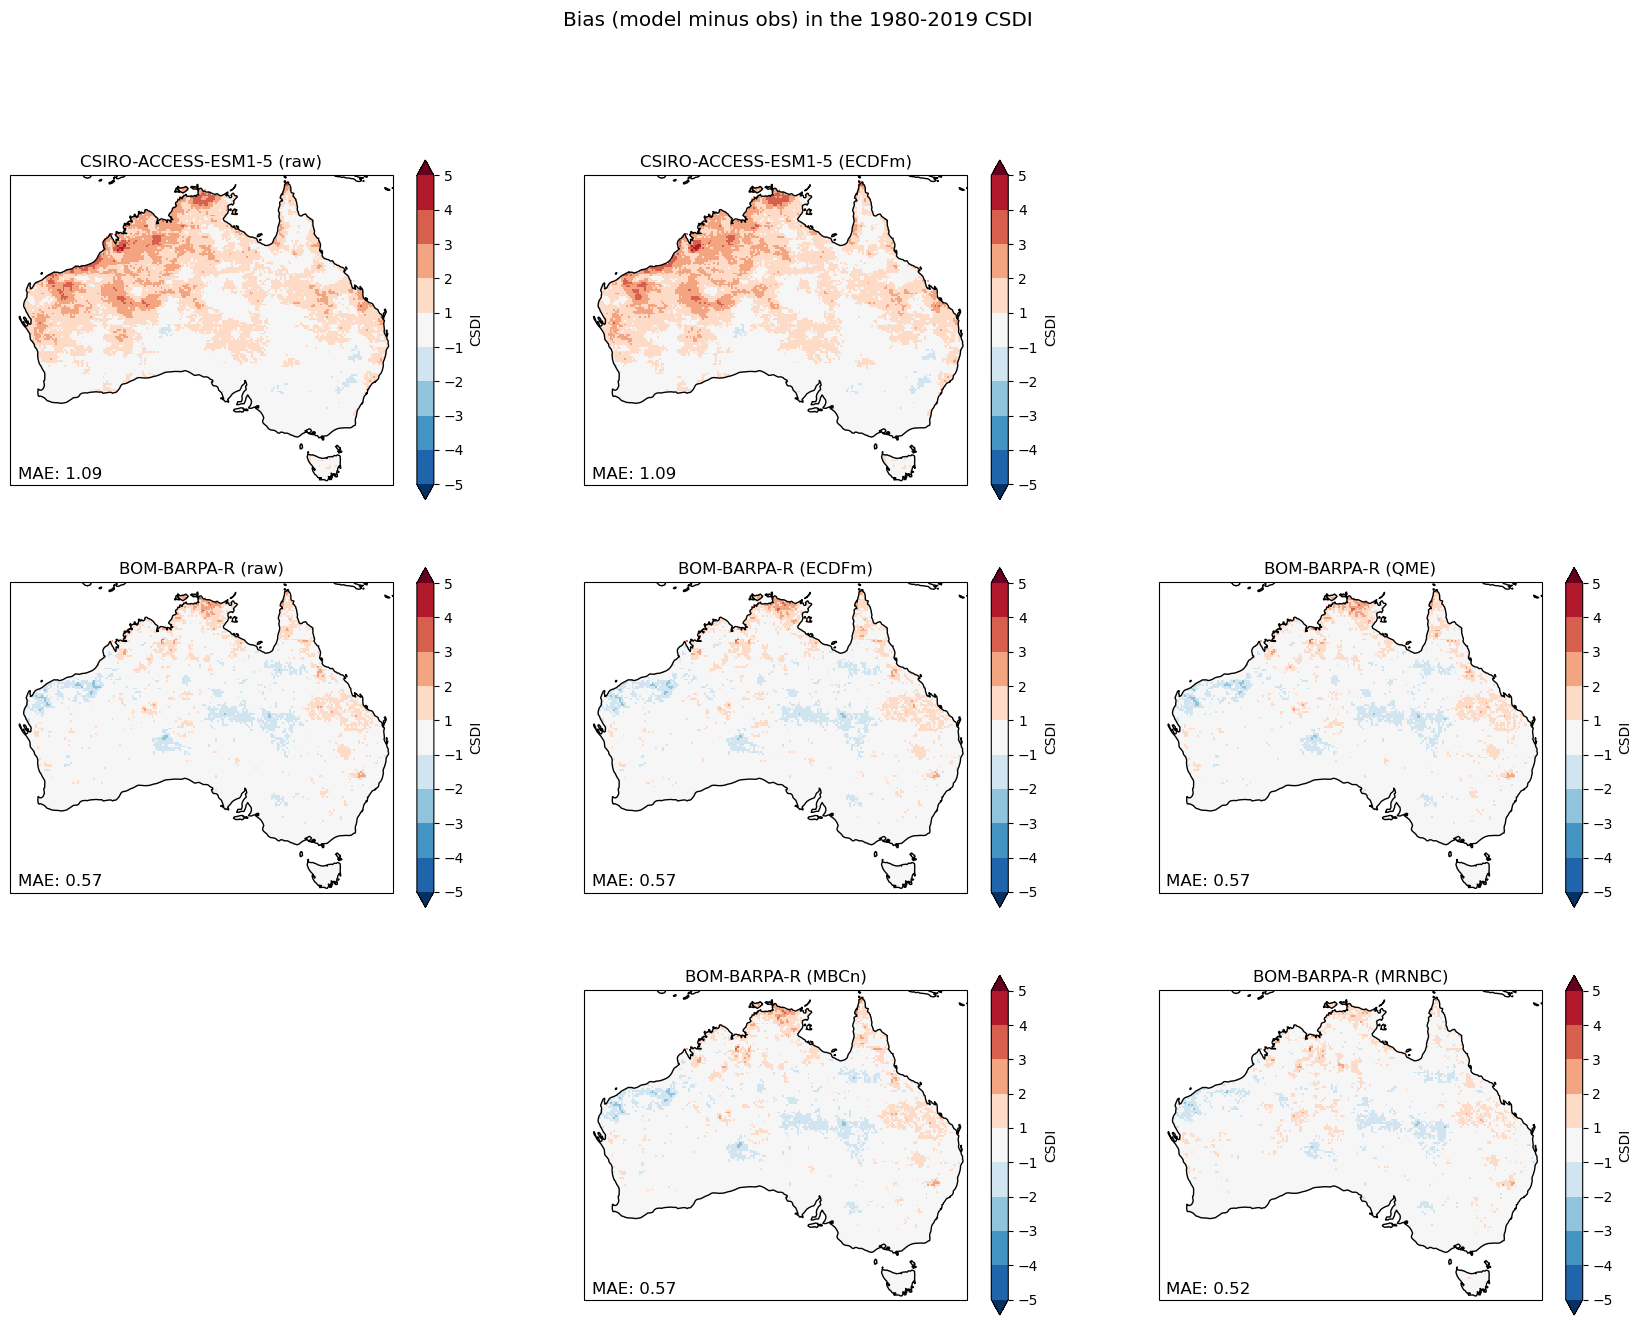

In [15]:
mae_data[task][f'{gcm}_{rcm}'] = plot_comparison(gcm, rcm, task, index, cmap=cmap_bias, levels=levels_bias)

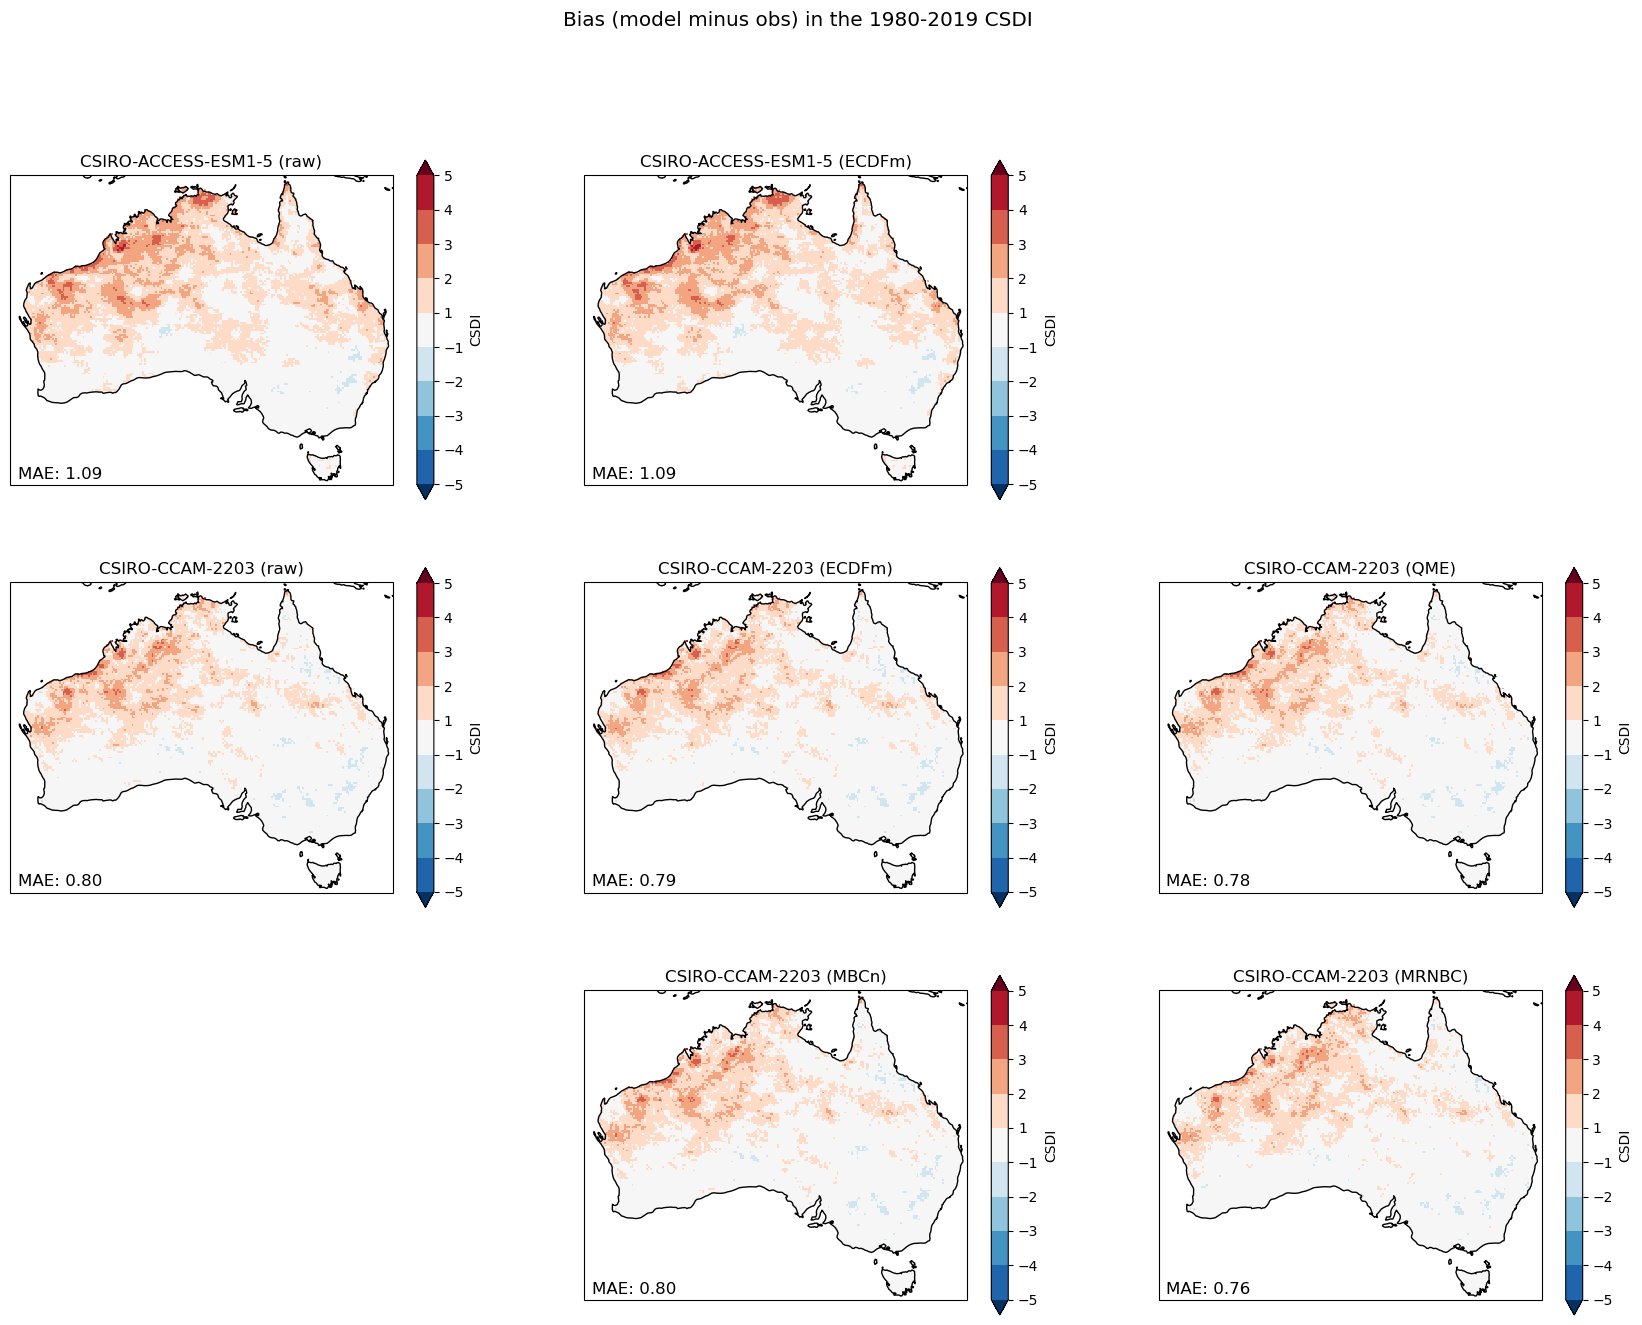

In [16]:
rcm = 'CSIRO-CCAM-2203'
mae_data[task][f'{gcm}_{rcm}'] = plot_comparison(gcm, rcm, task, index, cmap=cmap_bias, levels=levels_bias)

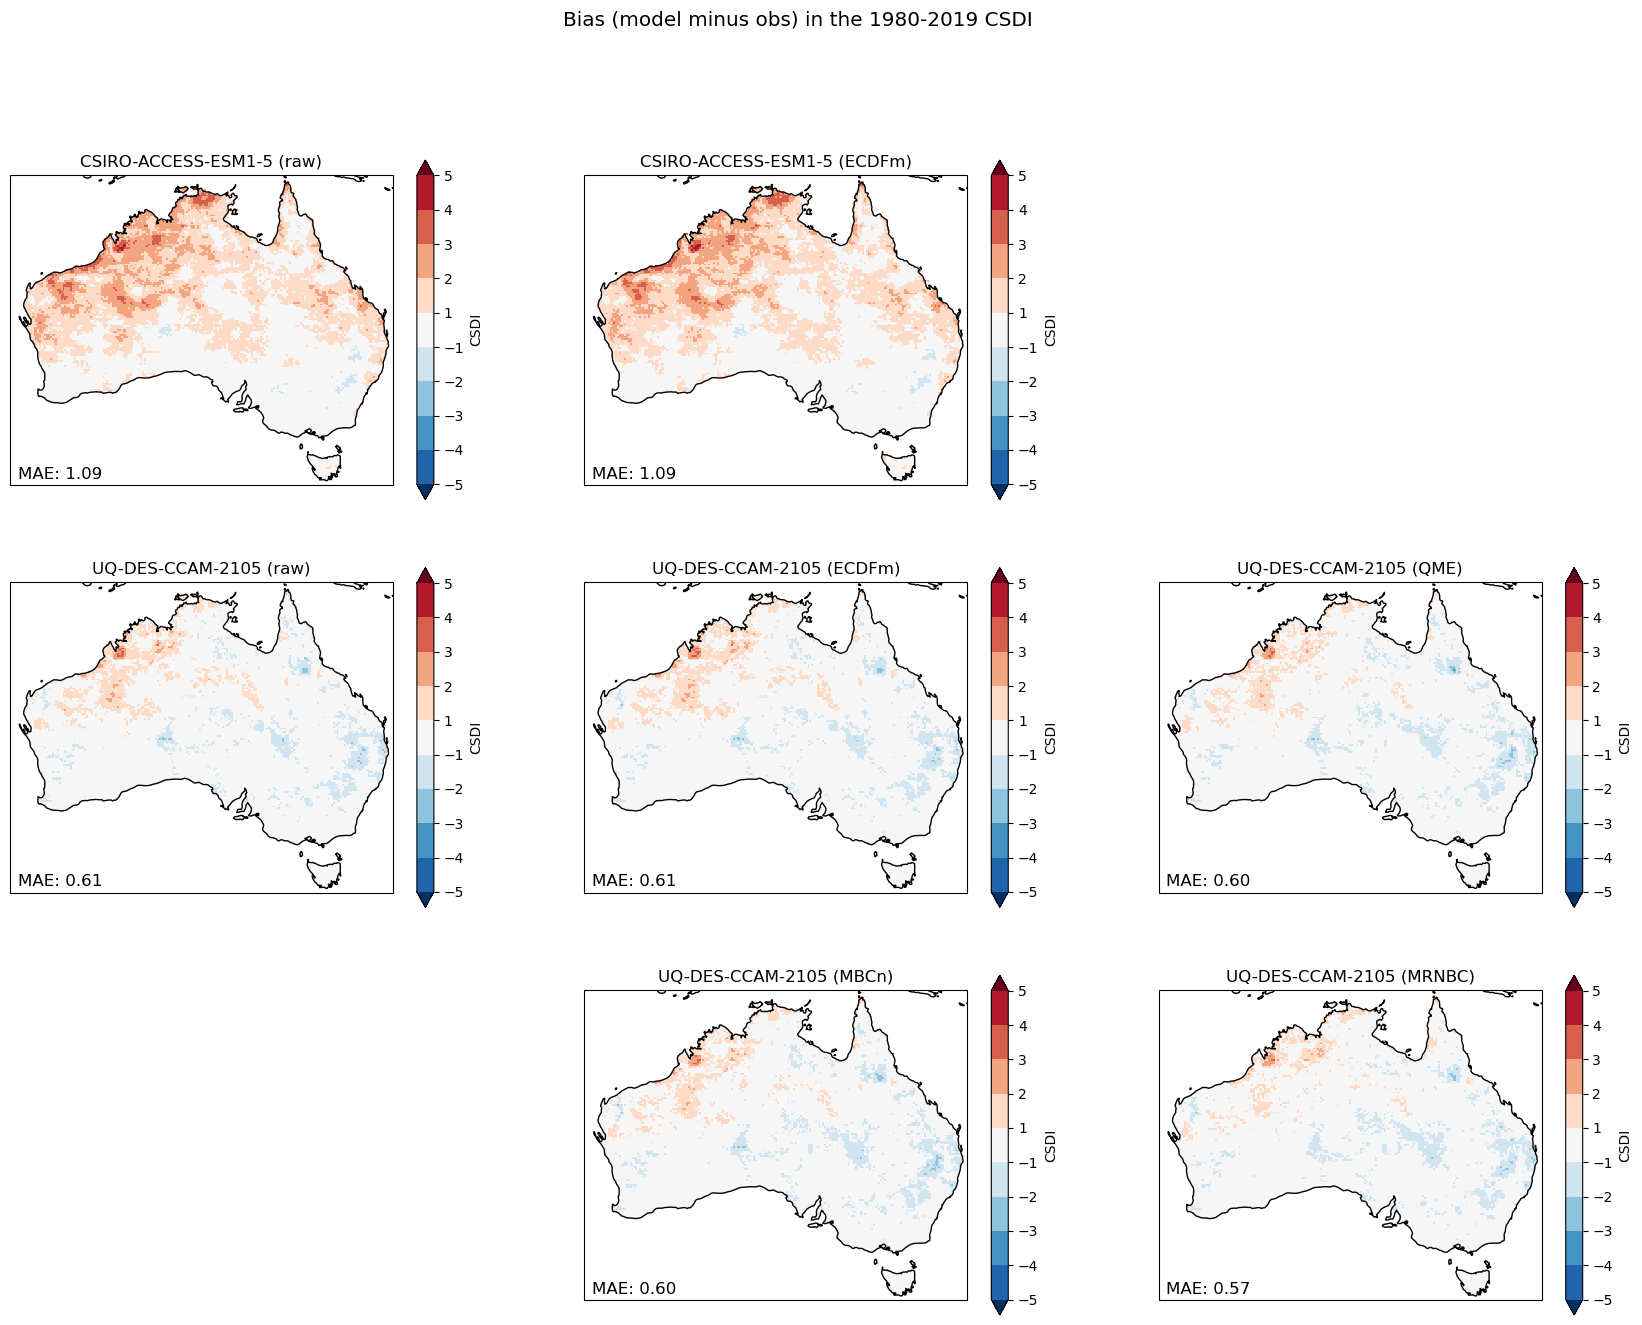

In [17]:
rcm = 'UQ-DES-CCAM-2105'
mae_data[task][f'{gcm}_{rcm}'] = plot_comparison(gcm, rcm, task, index, cmap=cmap_bias, levels=levels_bias)

#### CESM2

In [18]:
gcm = 'NCAR-CESM2'
task = 'historical'
rcm = 'BOM-BARPA-R'

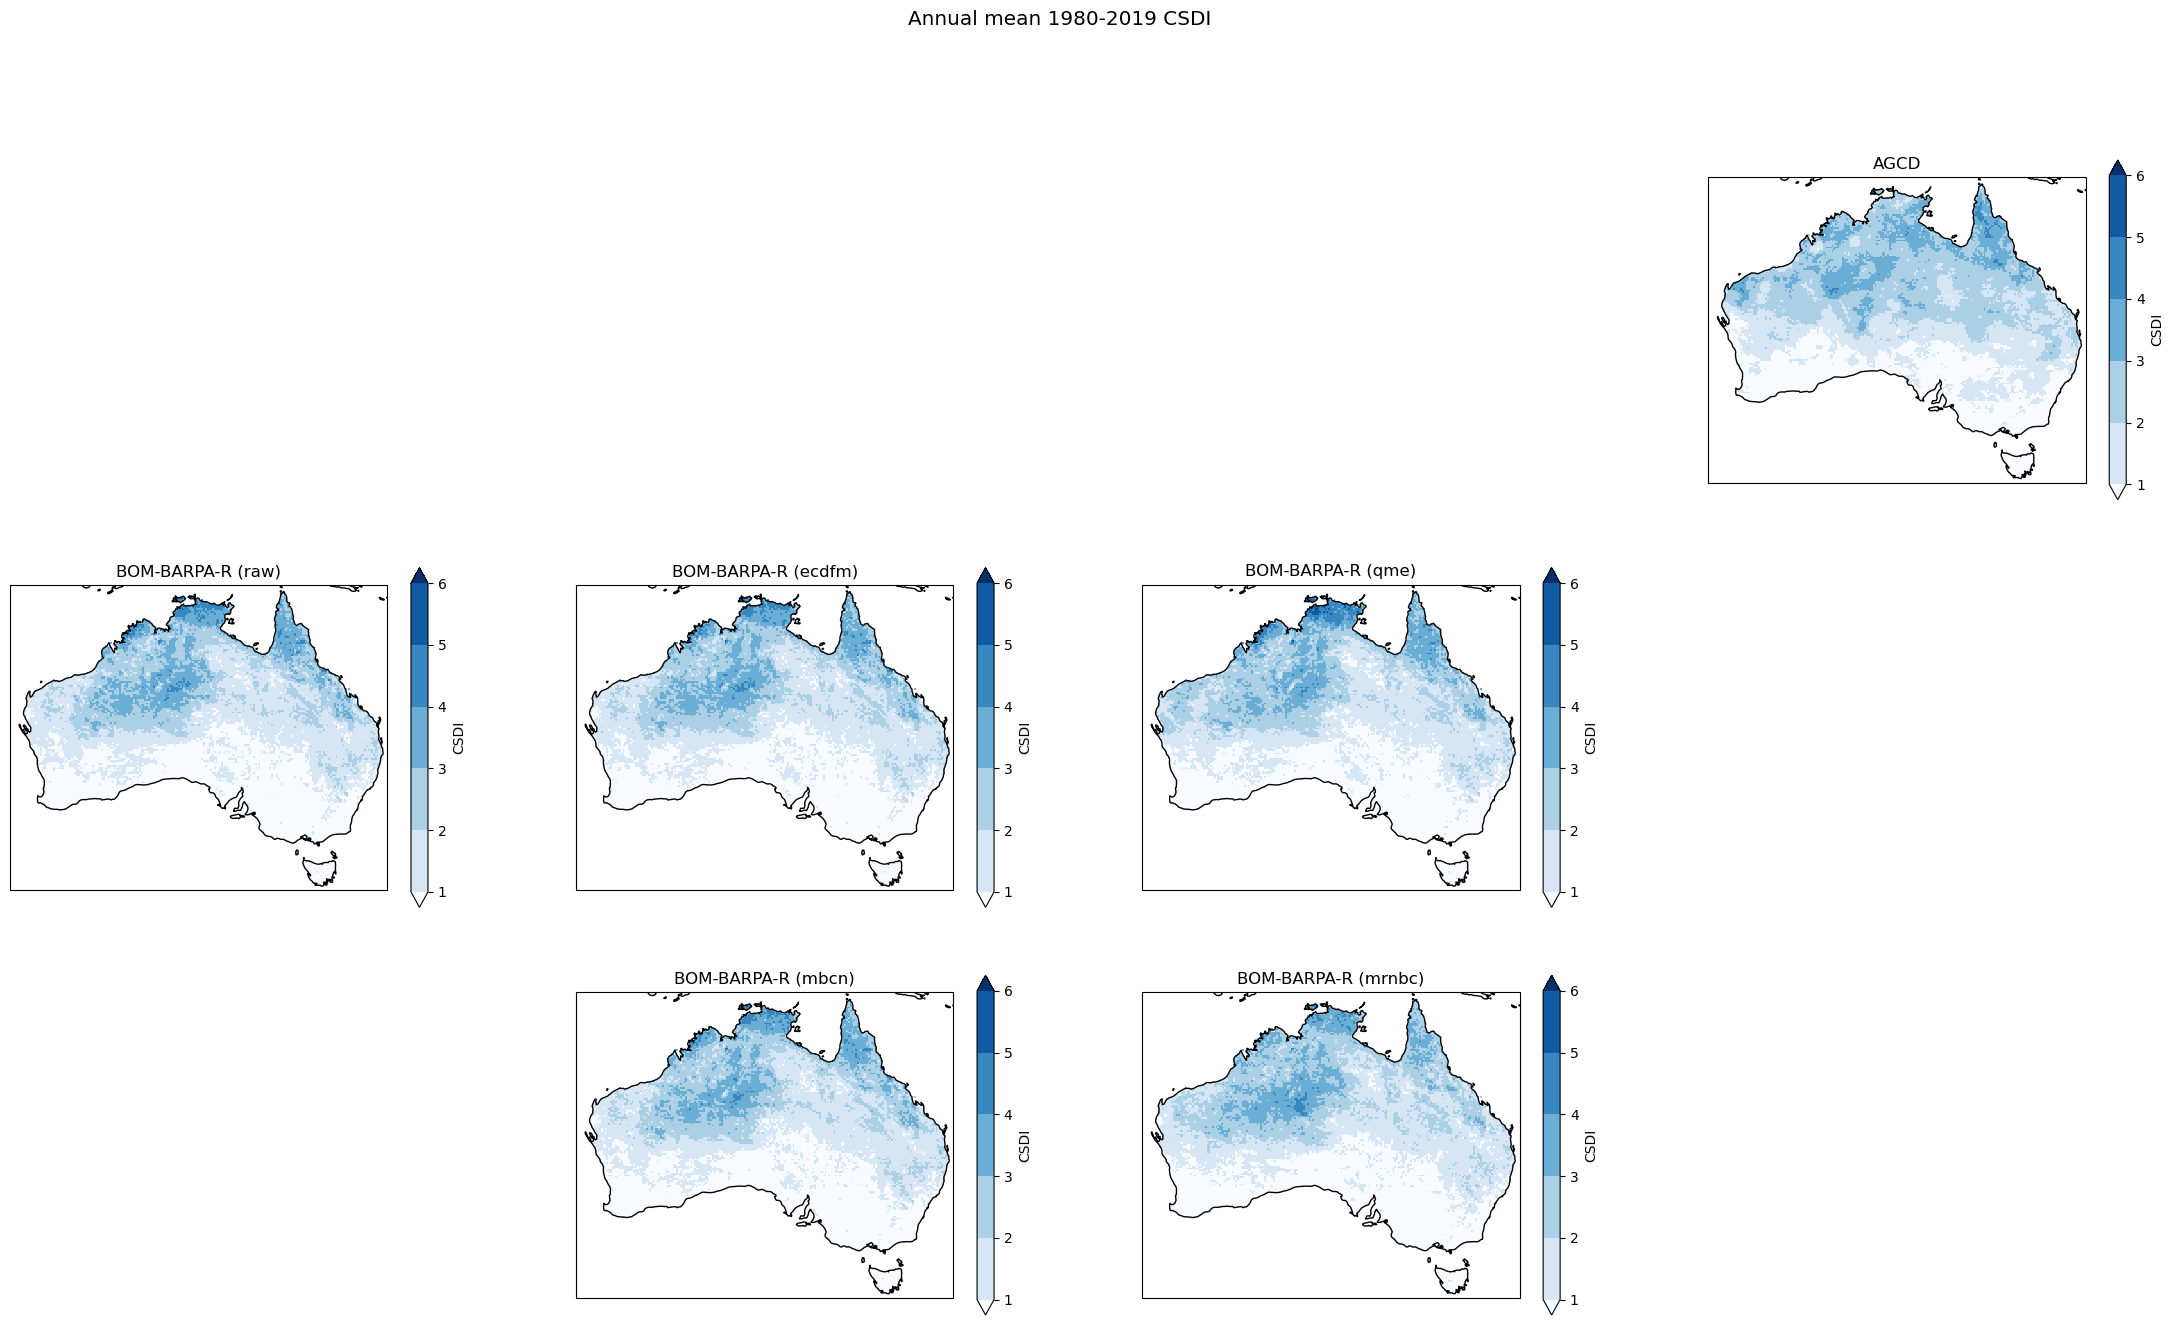

In [19]:
plot_values(gcm, rcm, task, index, cmap=cmap_values, levels=levels_values)

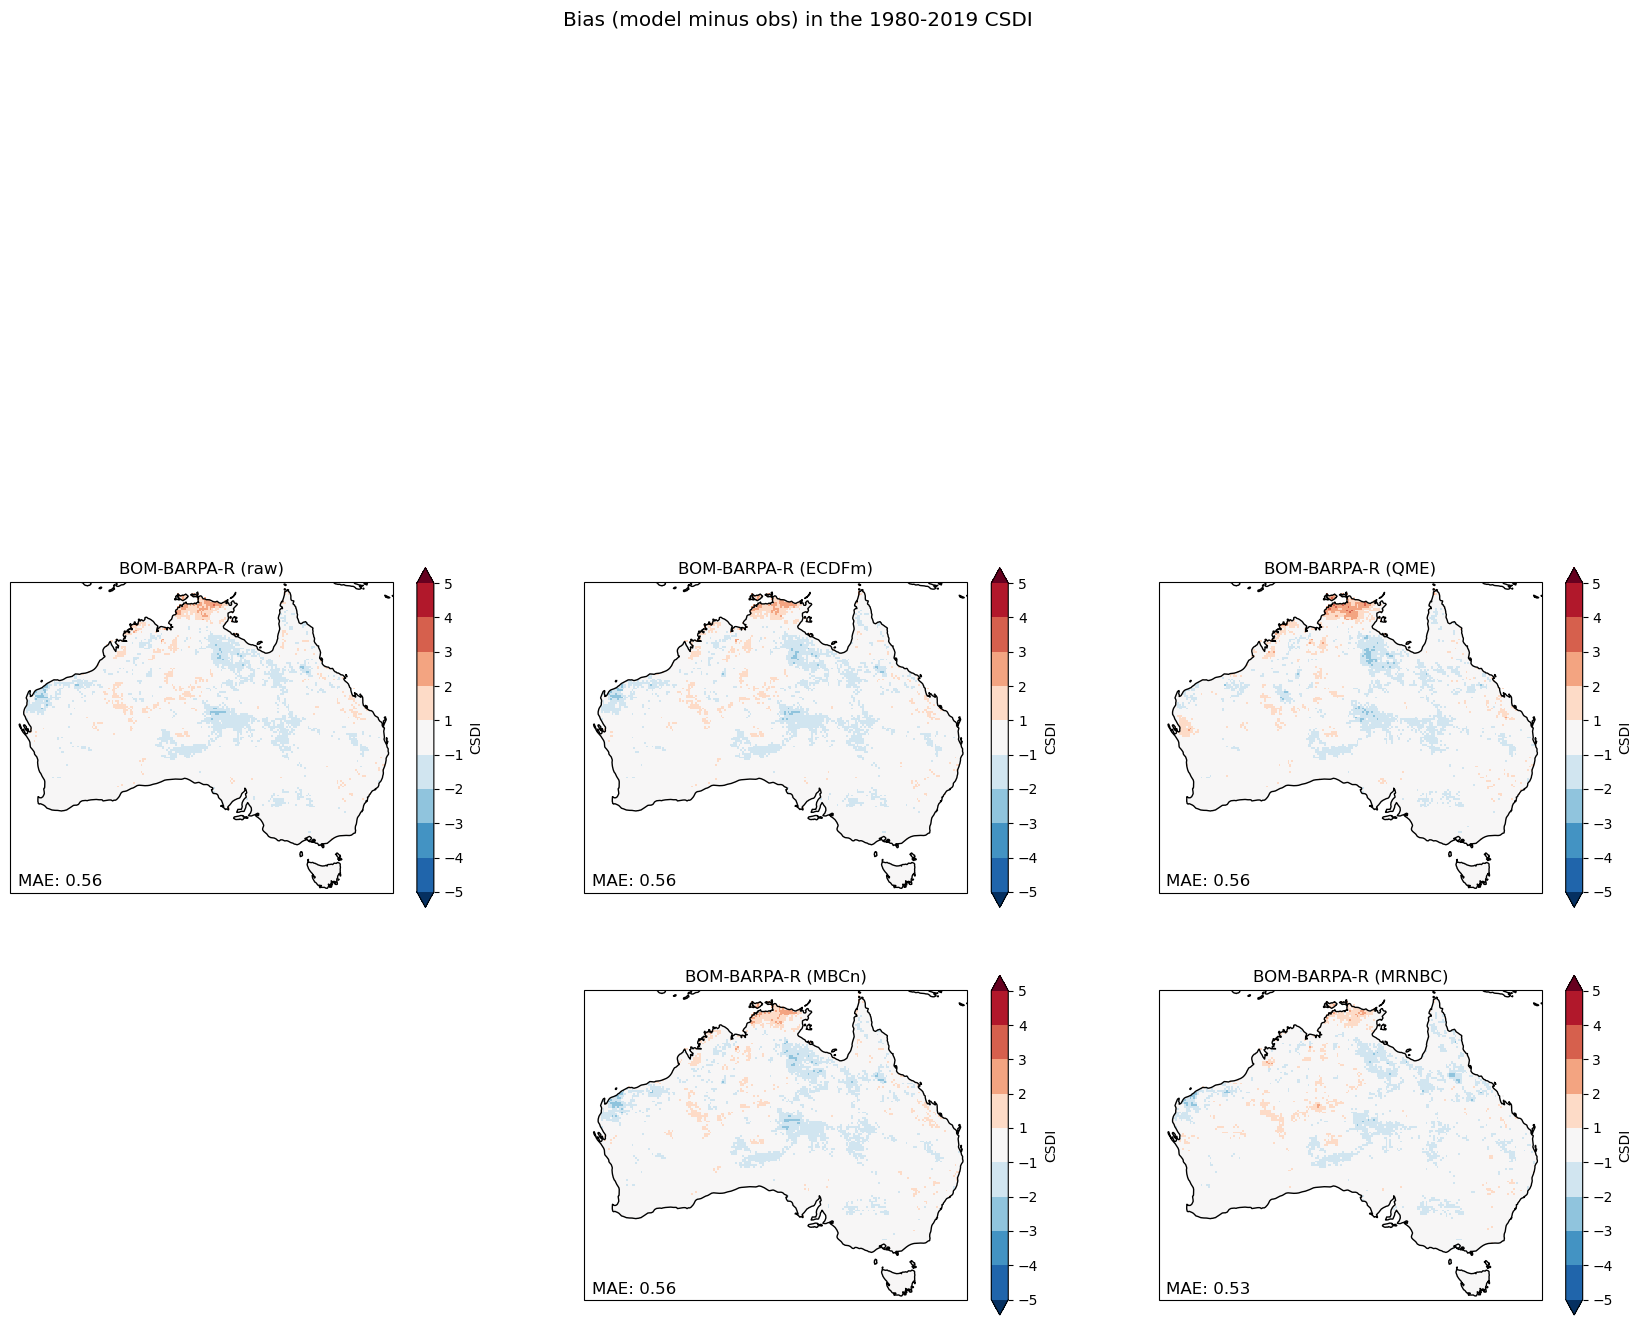

In [20]:
mae_data[task][f'{gcm}_{rcm}'] = plot_comparison(gcm, rcm, task, index, cmap=cmap_bias, levels=levels_bias)

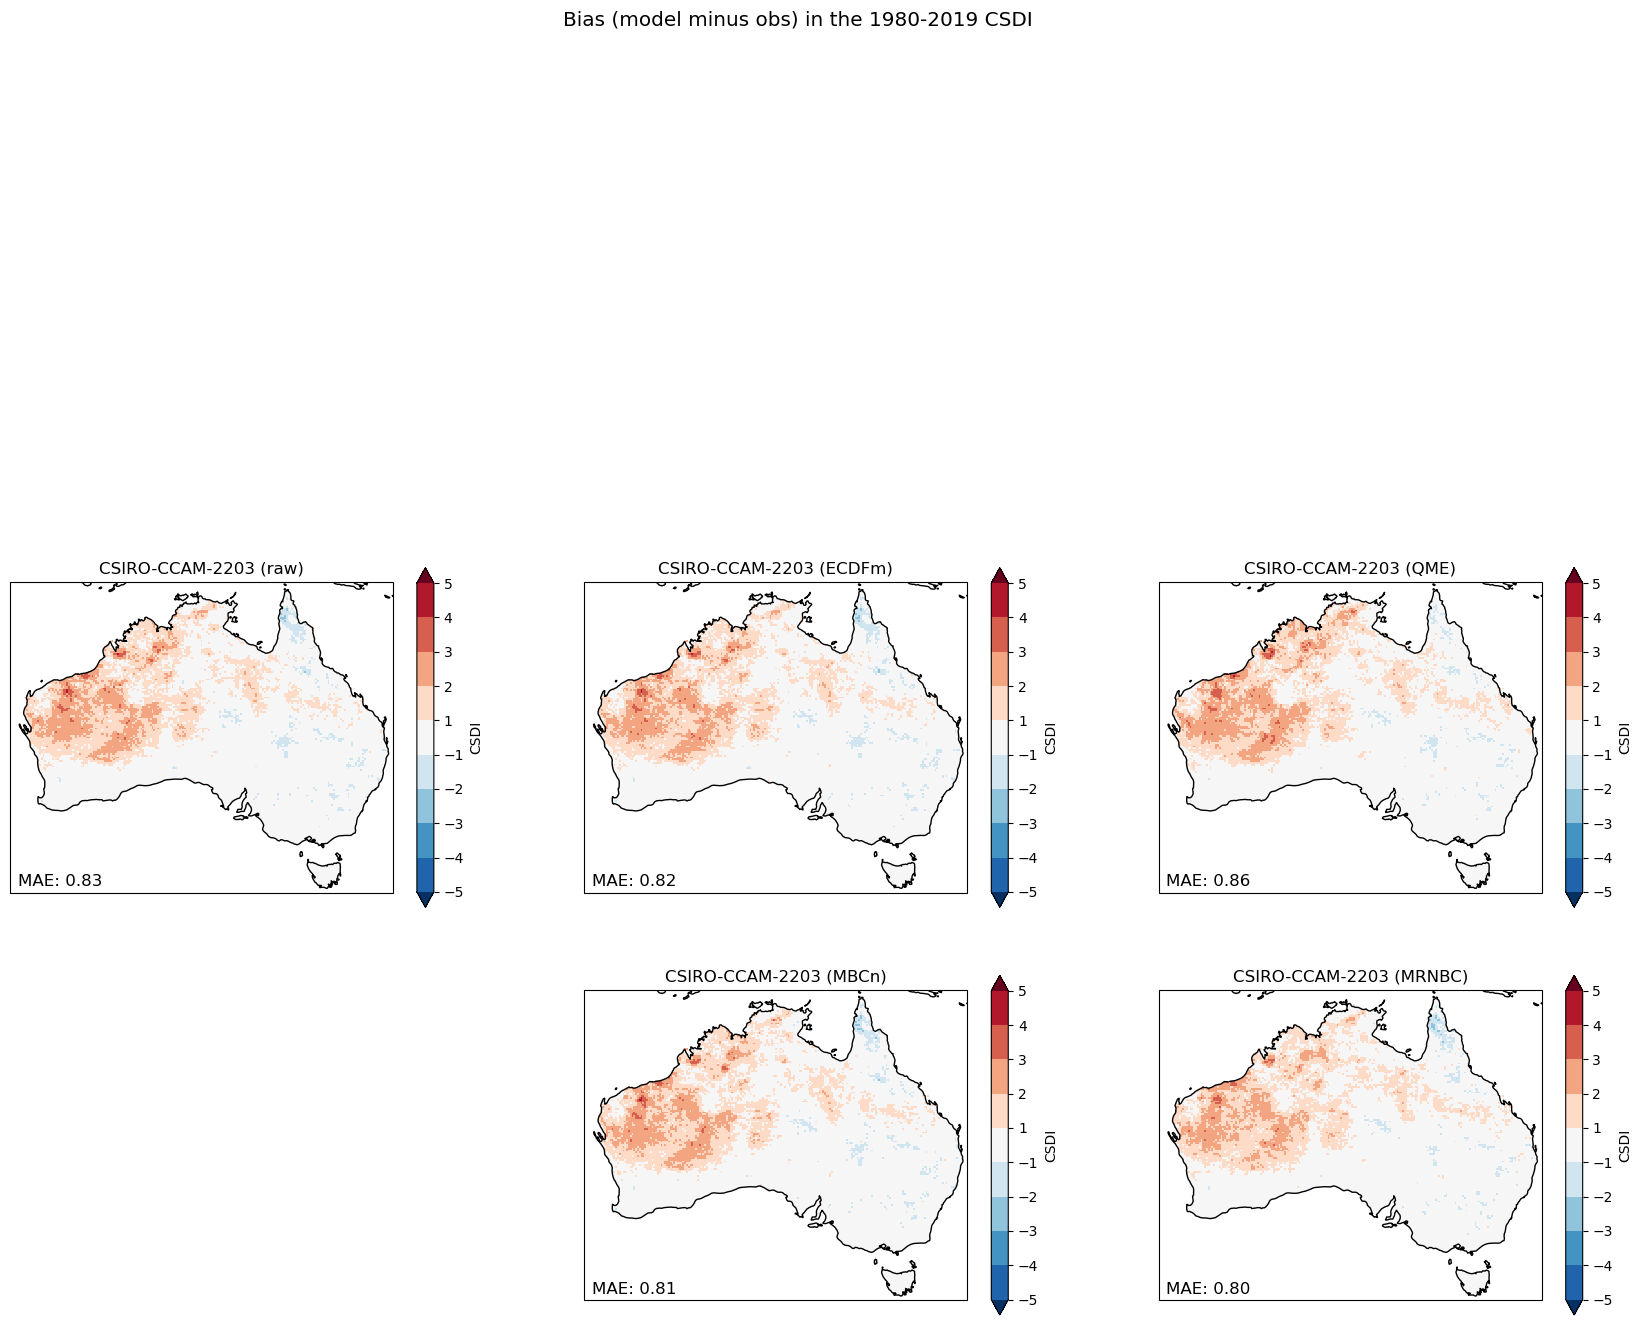

In [21]:
rcm = 'CSIRO-CCAM-2203'
mae_data[task][f'{gcm}_{rcm}'] = plot_comparison(gcm, rcm, task, index, cmap=cmap_bias, levels=levels_bias)

#### EC-Earth3

In [22]:
gcm = 'EC-Earth-Consortium-EC-Earth3'
task = 'historical'
rcm = 'BOM-BARPA-R'

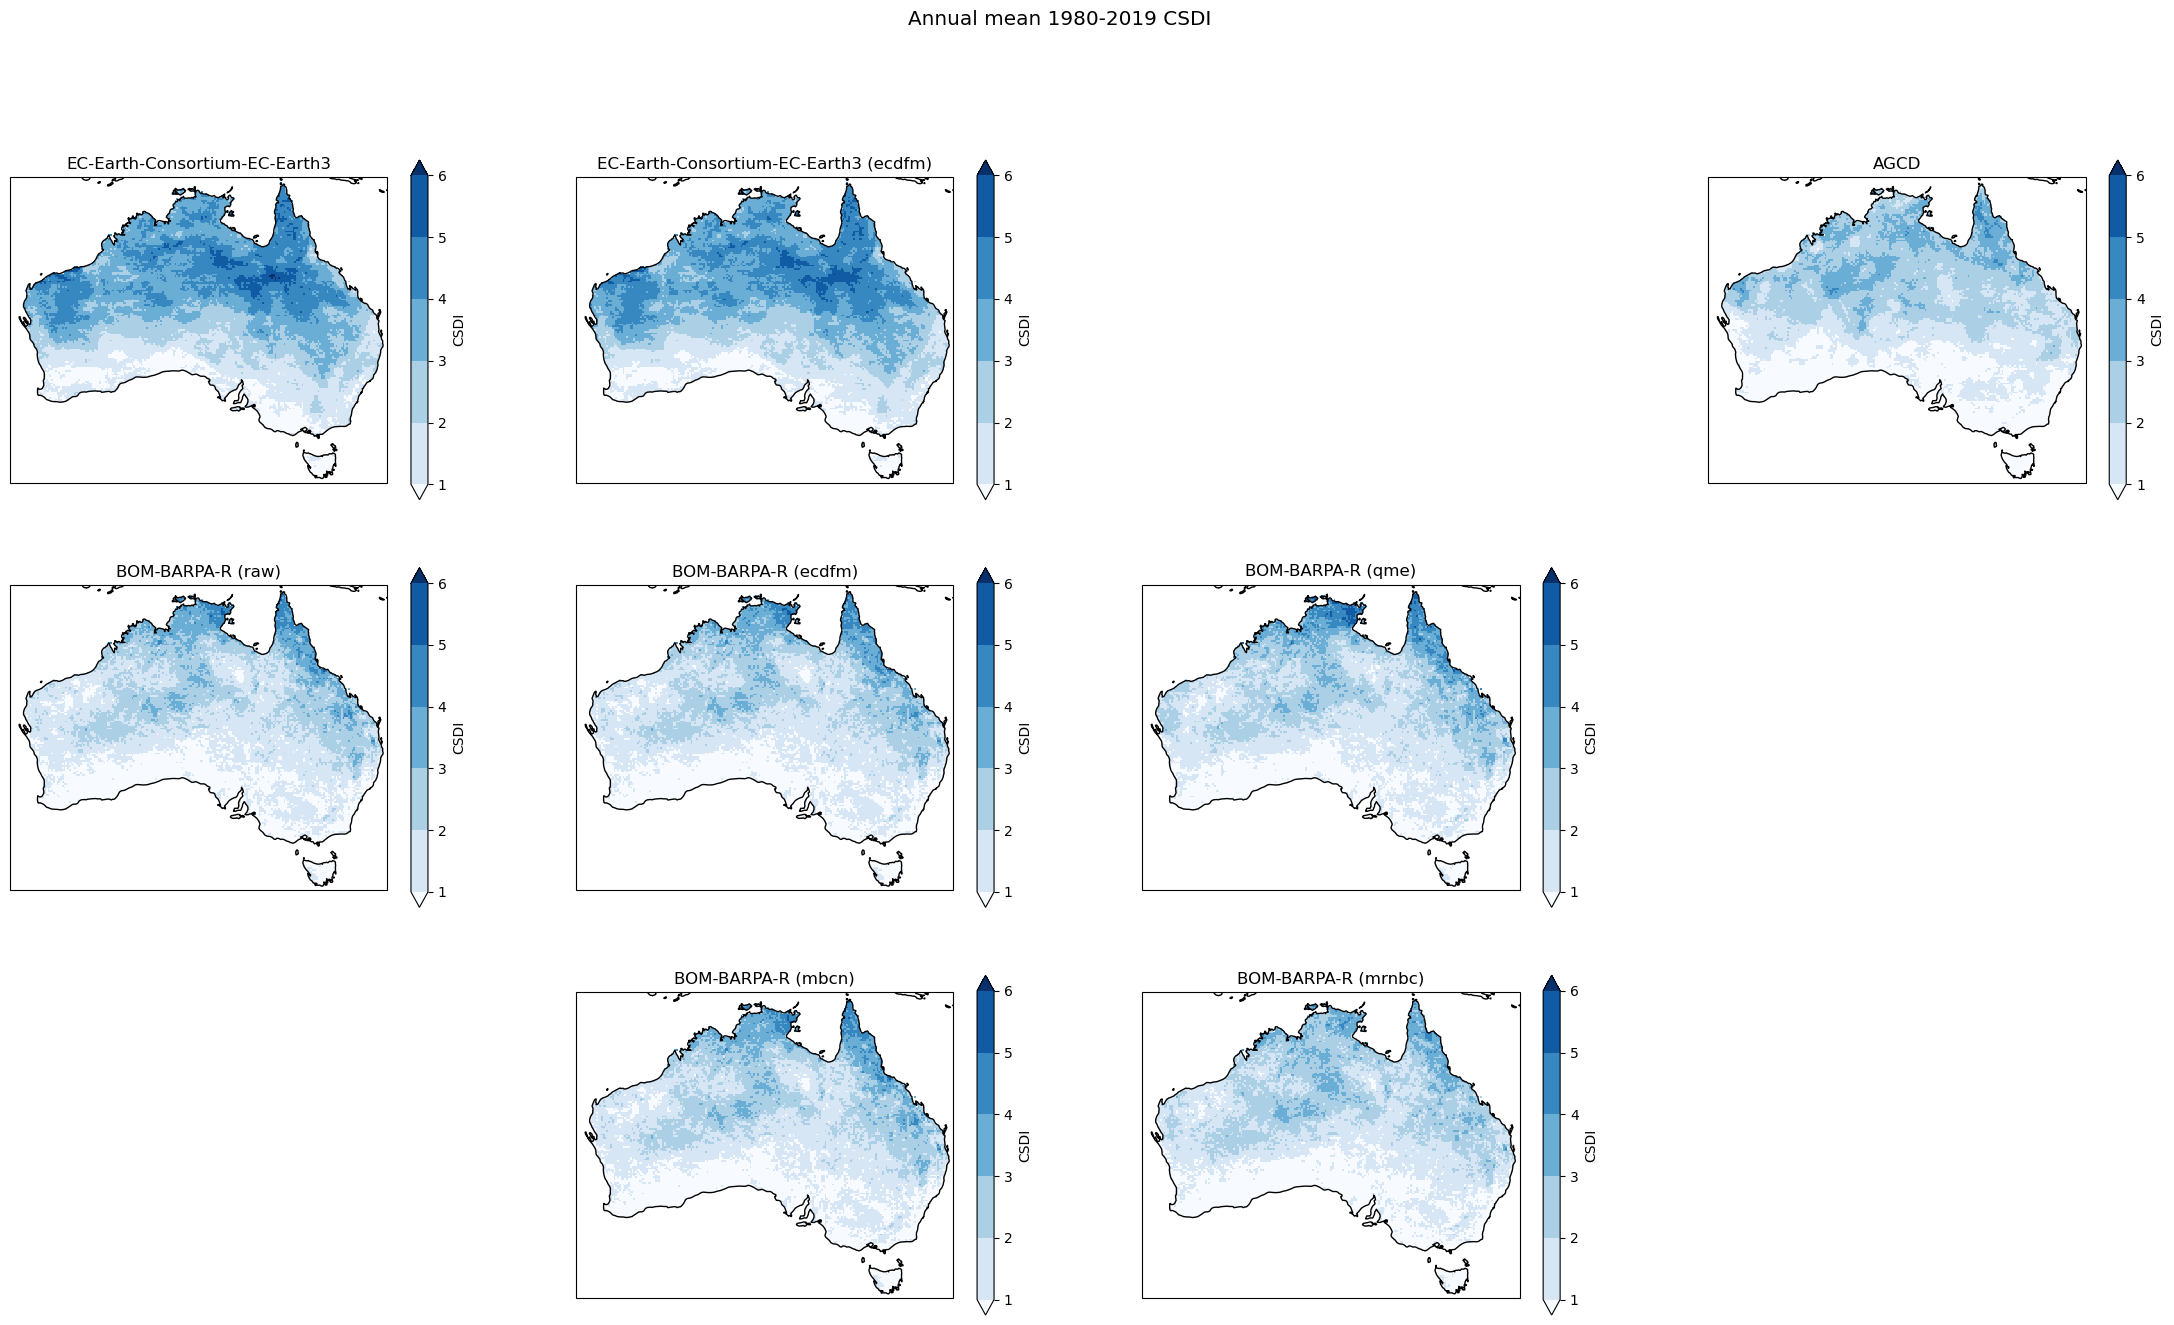

In [23]:
plot_values(gcm, rcm, task, index, cmap=cmap_values, levels=levels_values)

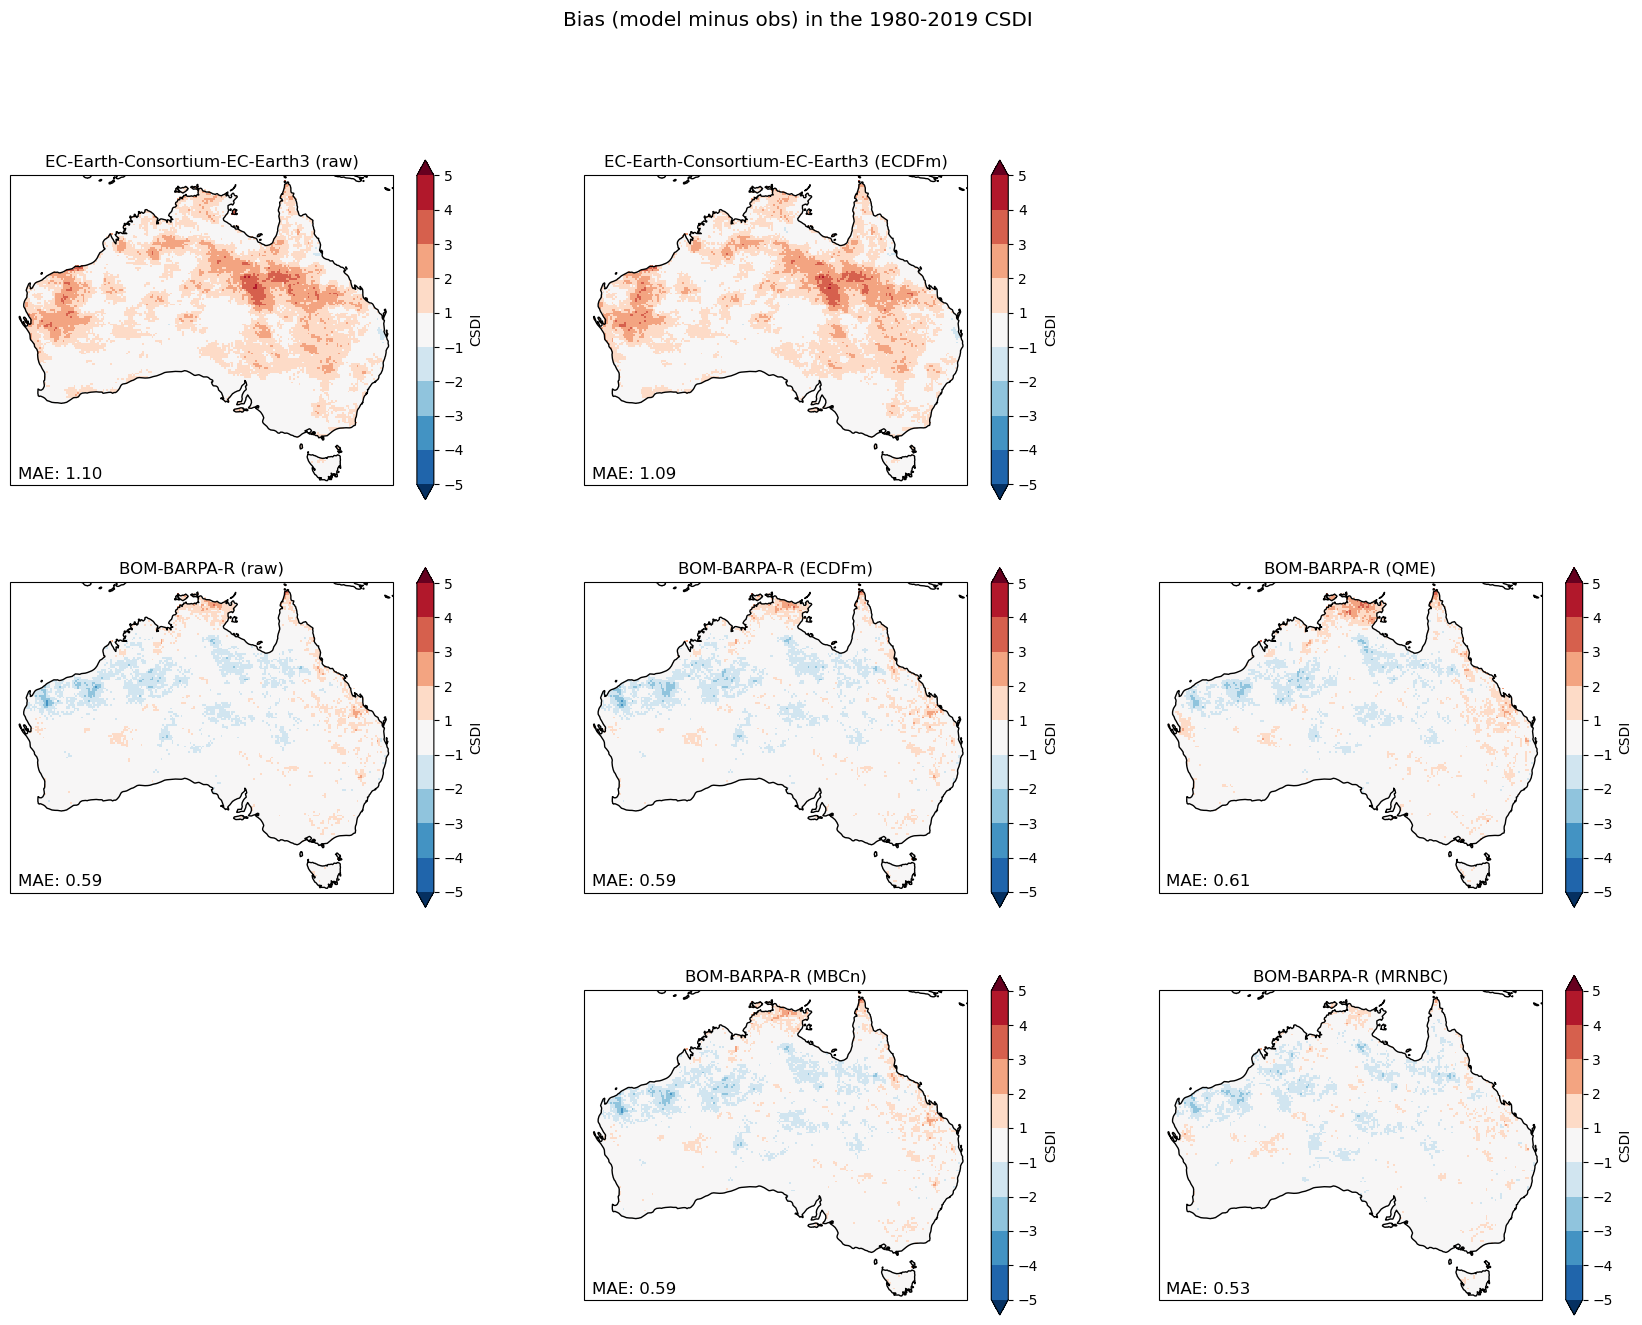

In [24]:
mae_data[task][f'{gcm}_{rcm}'] = plot_comparison(gcm, rcm, task, index, cmap=cmap_bias, levels=levels_bias)

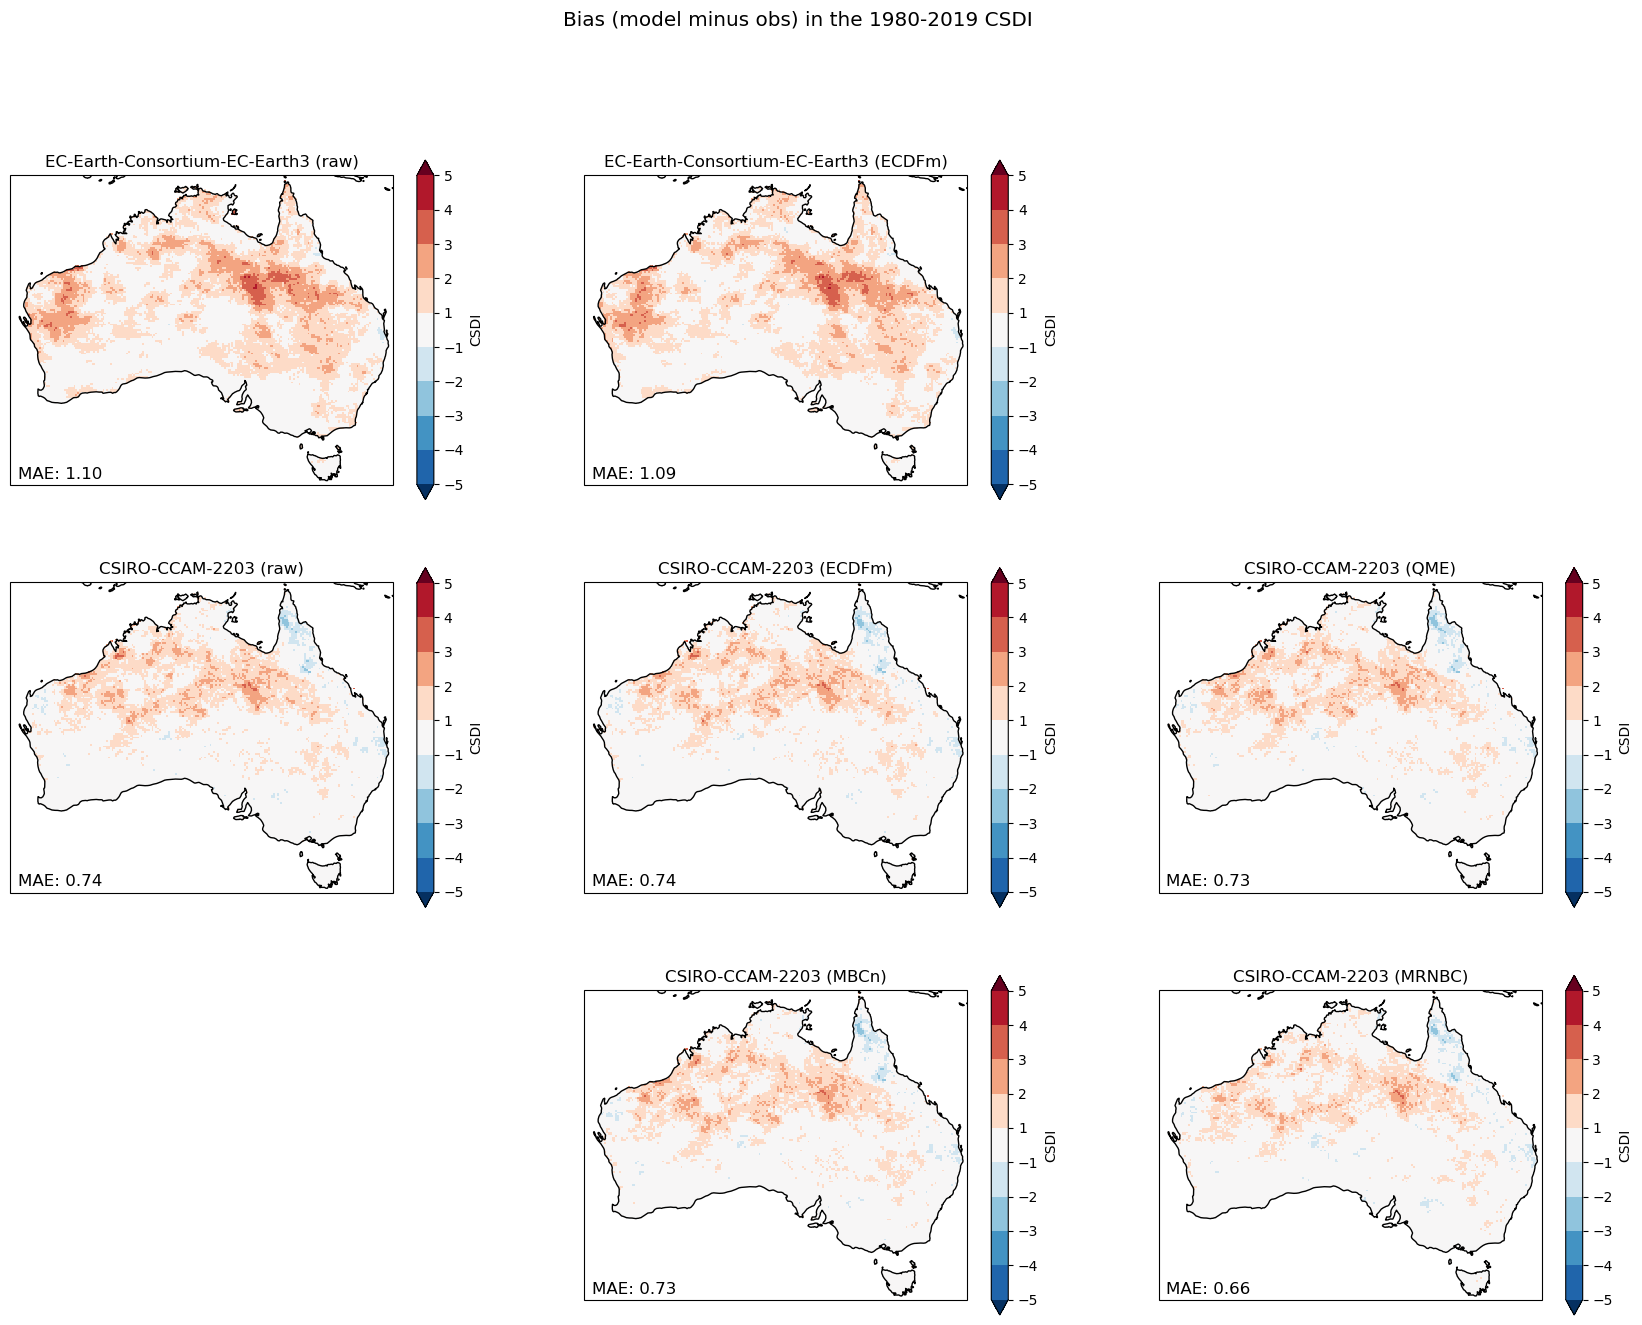

In [25]:
rcm = 'CSIRO-CCAM-2203'
mae_data[task][f'{gcm}_{rcm}'] = plot_comparison(gcm, rcm, task, index, cmap=cmap_bias, levels=levels_bias)

## task-xvalidation

In [8]:
task = 'xvalidation'
mae_data[task] = {}

#### ERA5

Bias corrected data for the 2000-2019 period, using 1980-1999 as a training period.

In [27]:
#gcm = 'ECMWF-ERA5'
#task = 'xvalidation'

In [28]:
#rcm = 'BOM-BARPA-R'
# plot_values()
# plot_comparison()

In [29]:
#rcm = 'CSIRO-CCAM-2203'
# plot_values()
# plot_comparison()

In [30]:
#rcm = 'UQ-DES-CCAM-2105'
# plot_values()
# plot_comparison()

#### ACCESS-ESM1-5

Bias corrected data for the 1990-2019 period, using 1960-1989 as a training period.

In [10]:
gcm = 'CSIRO-ACCESS-ESM1-5'
task = 'xvalidation'
rcm = 'BOM-BARPA-R'

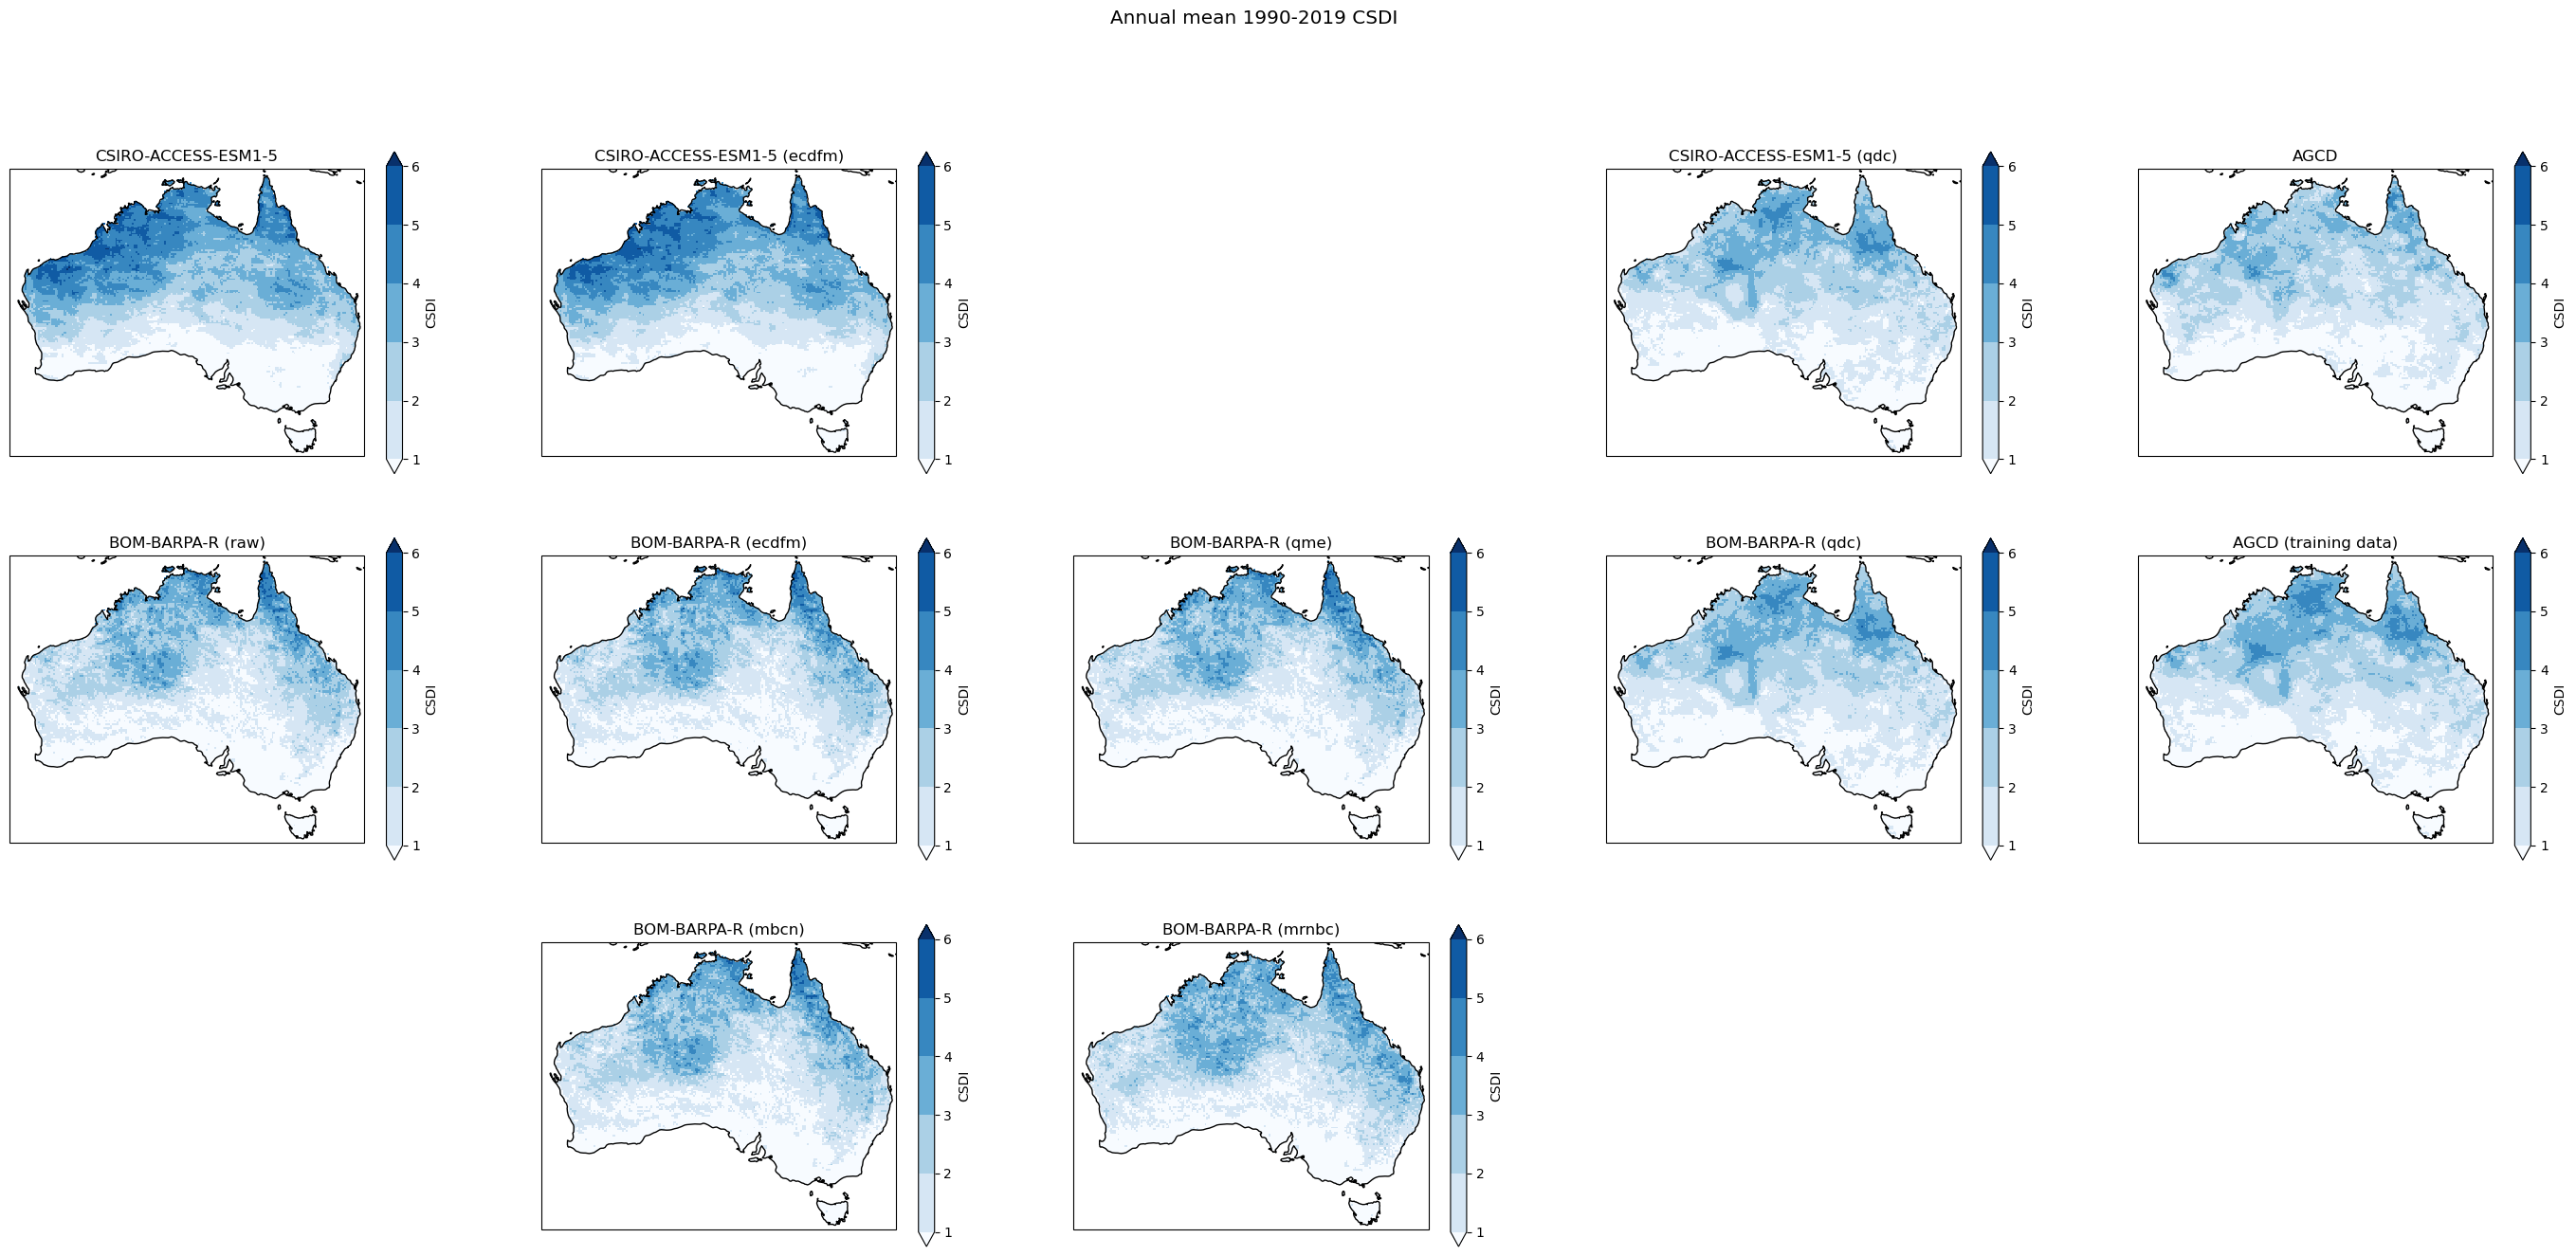

In [32]:
plot_values(gcm, rcm, task, index, cmap=cmap_values, levels=levels_values, outfile=False)

/g/data/ia39/npcp/code/results/figures/CSDI-bias_task-xvalidation_CSIRO-ACCESS-ESM1-5_BOM-BARPA-R.png


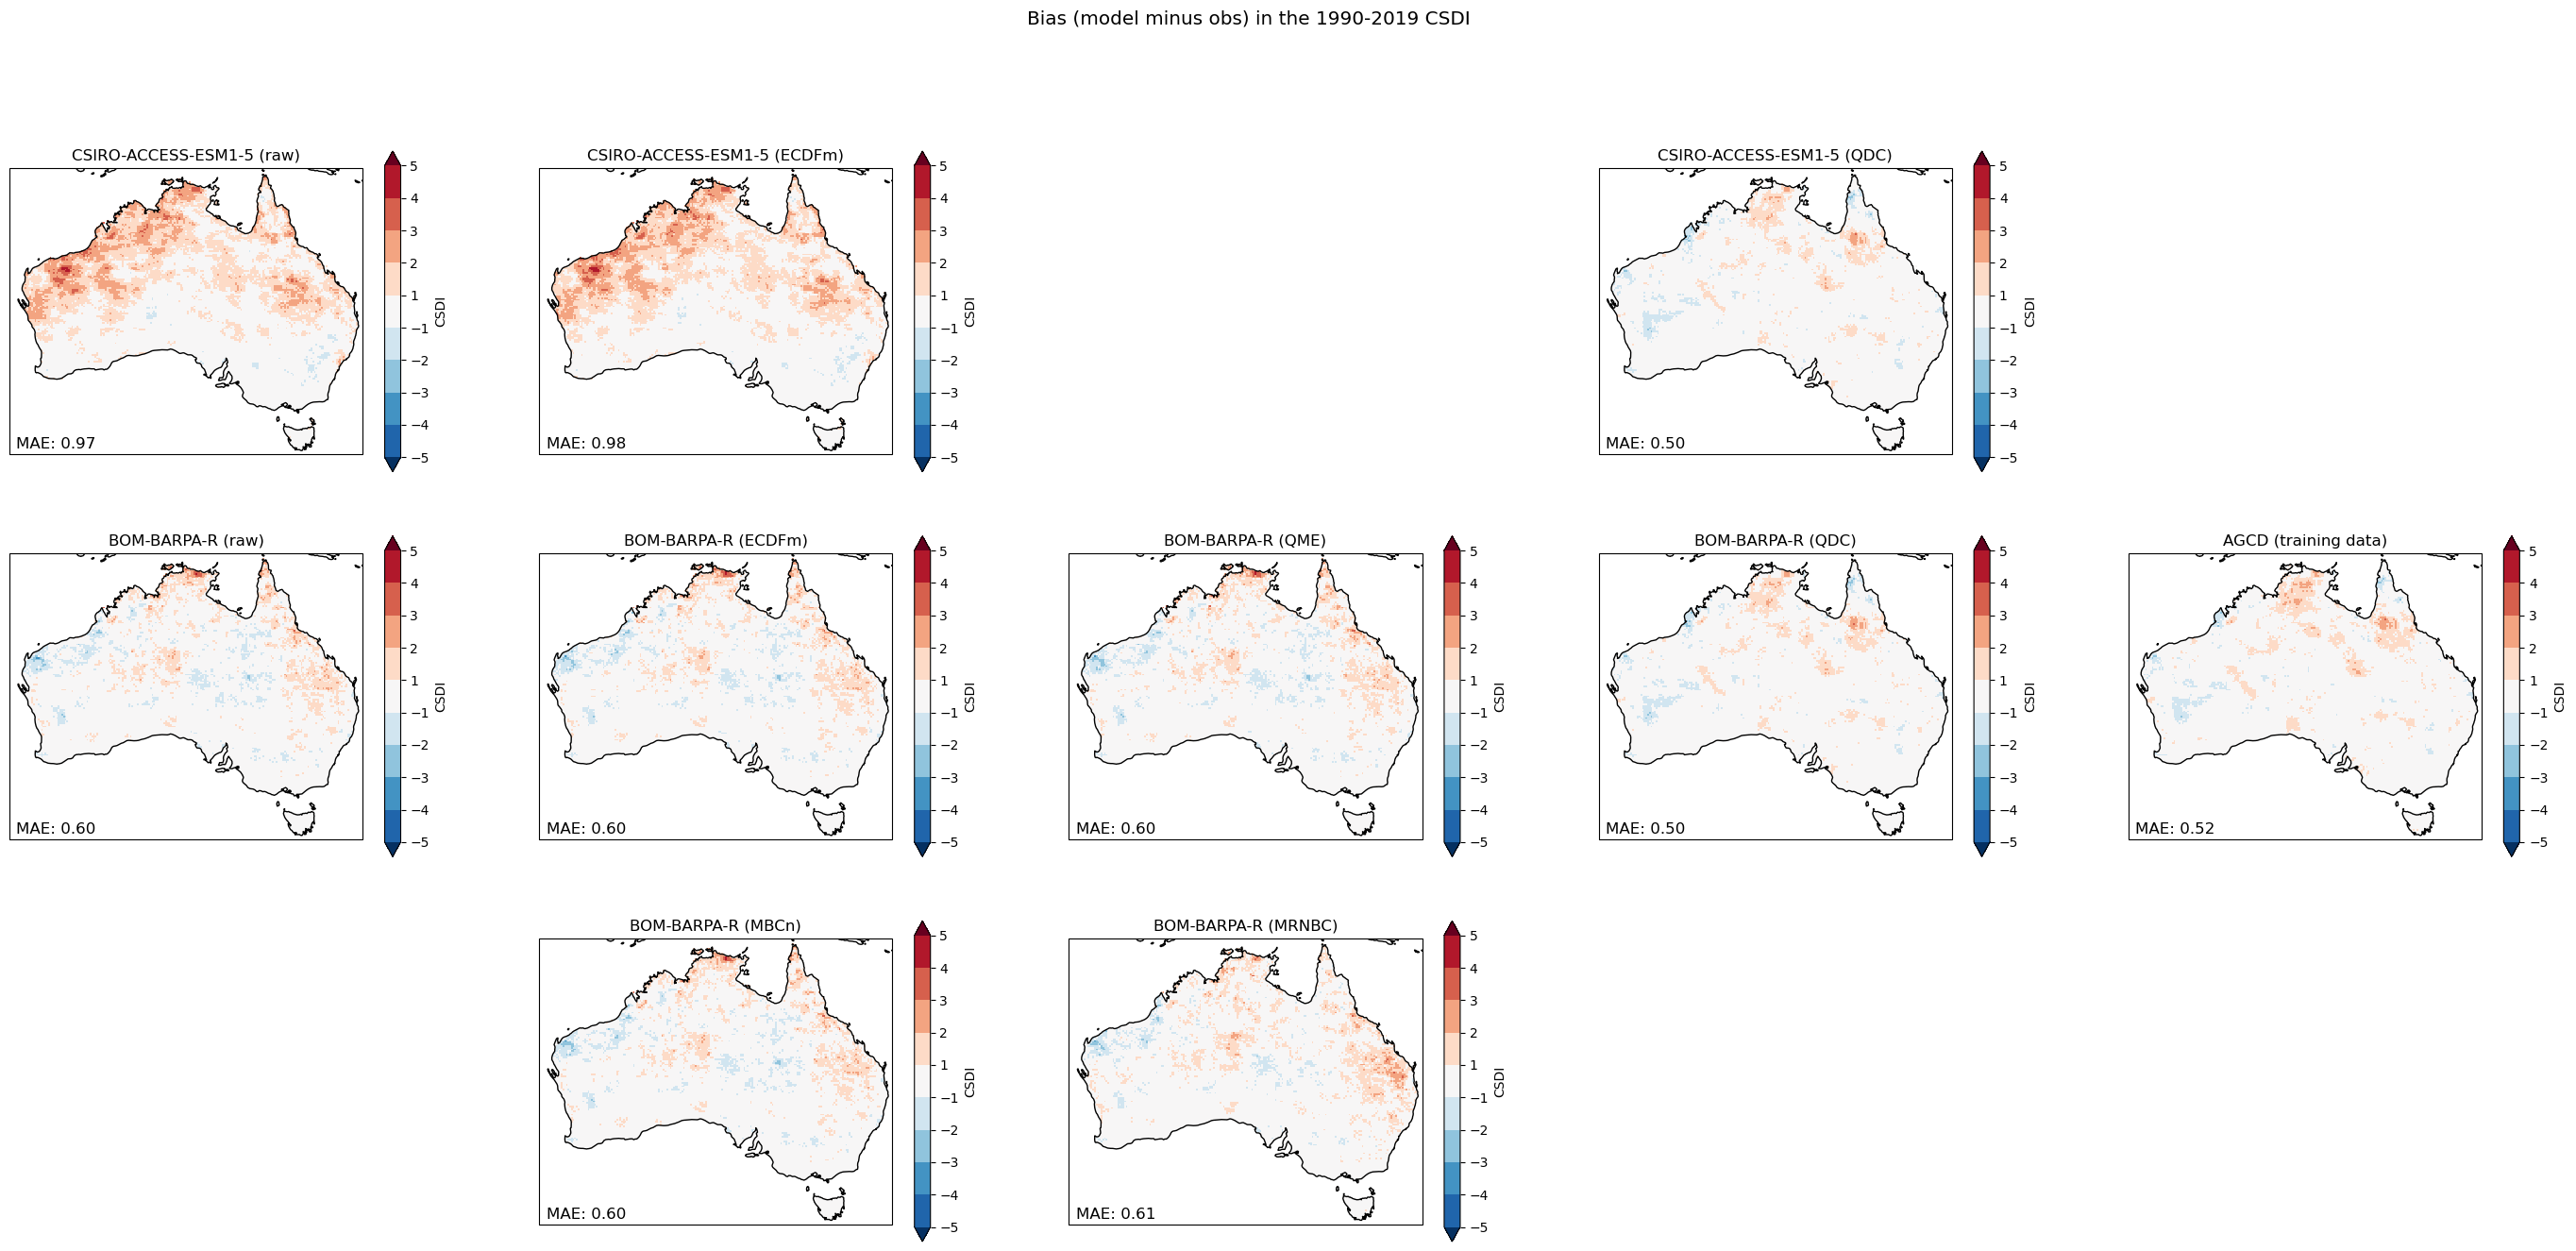

In [11]:
mae_data[task][f'{gcm}_{rcm}'] = plot_comparison(gcm, rcm, task, index, cmap=cmap_bias, levels=levels_bias, outfile=True)

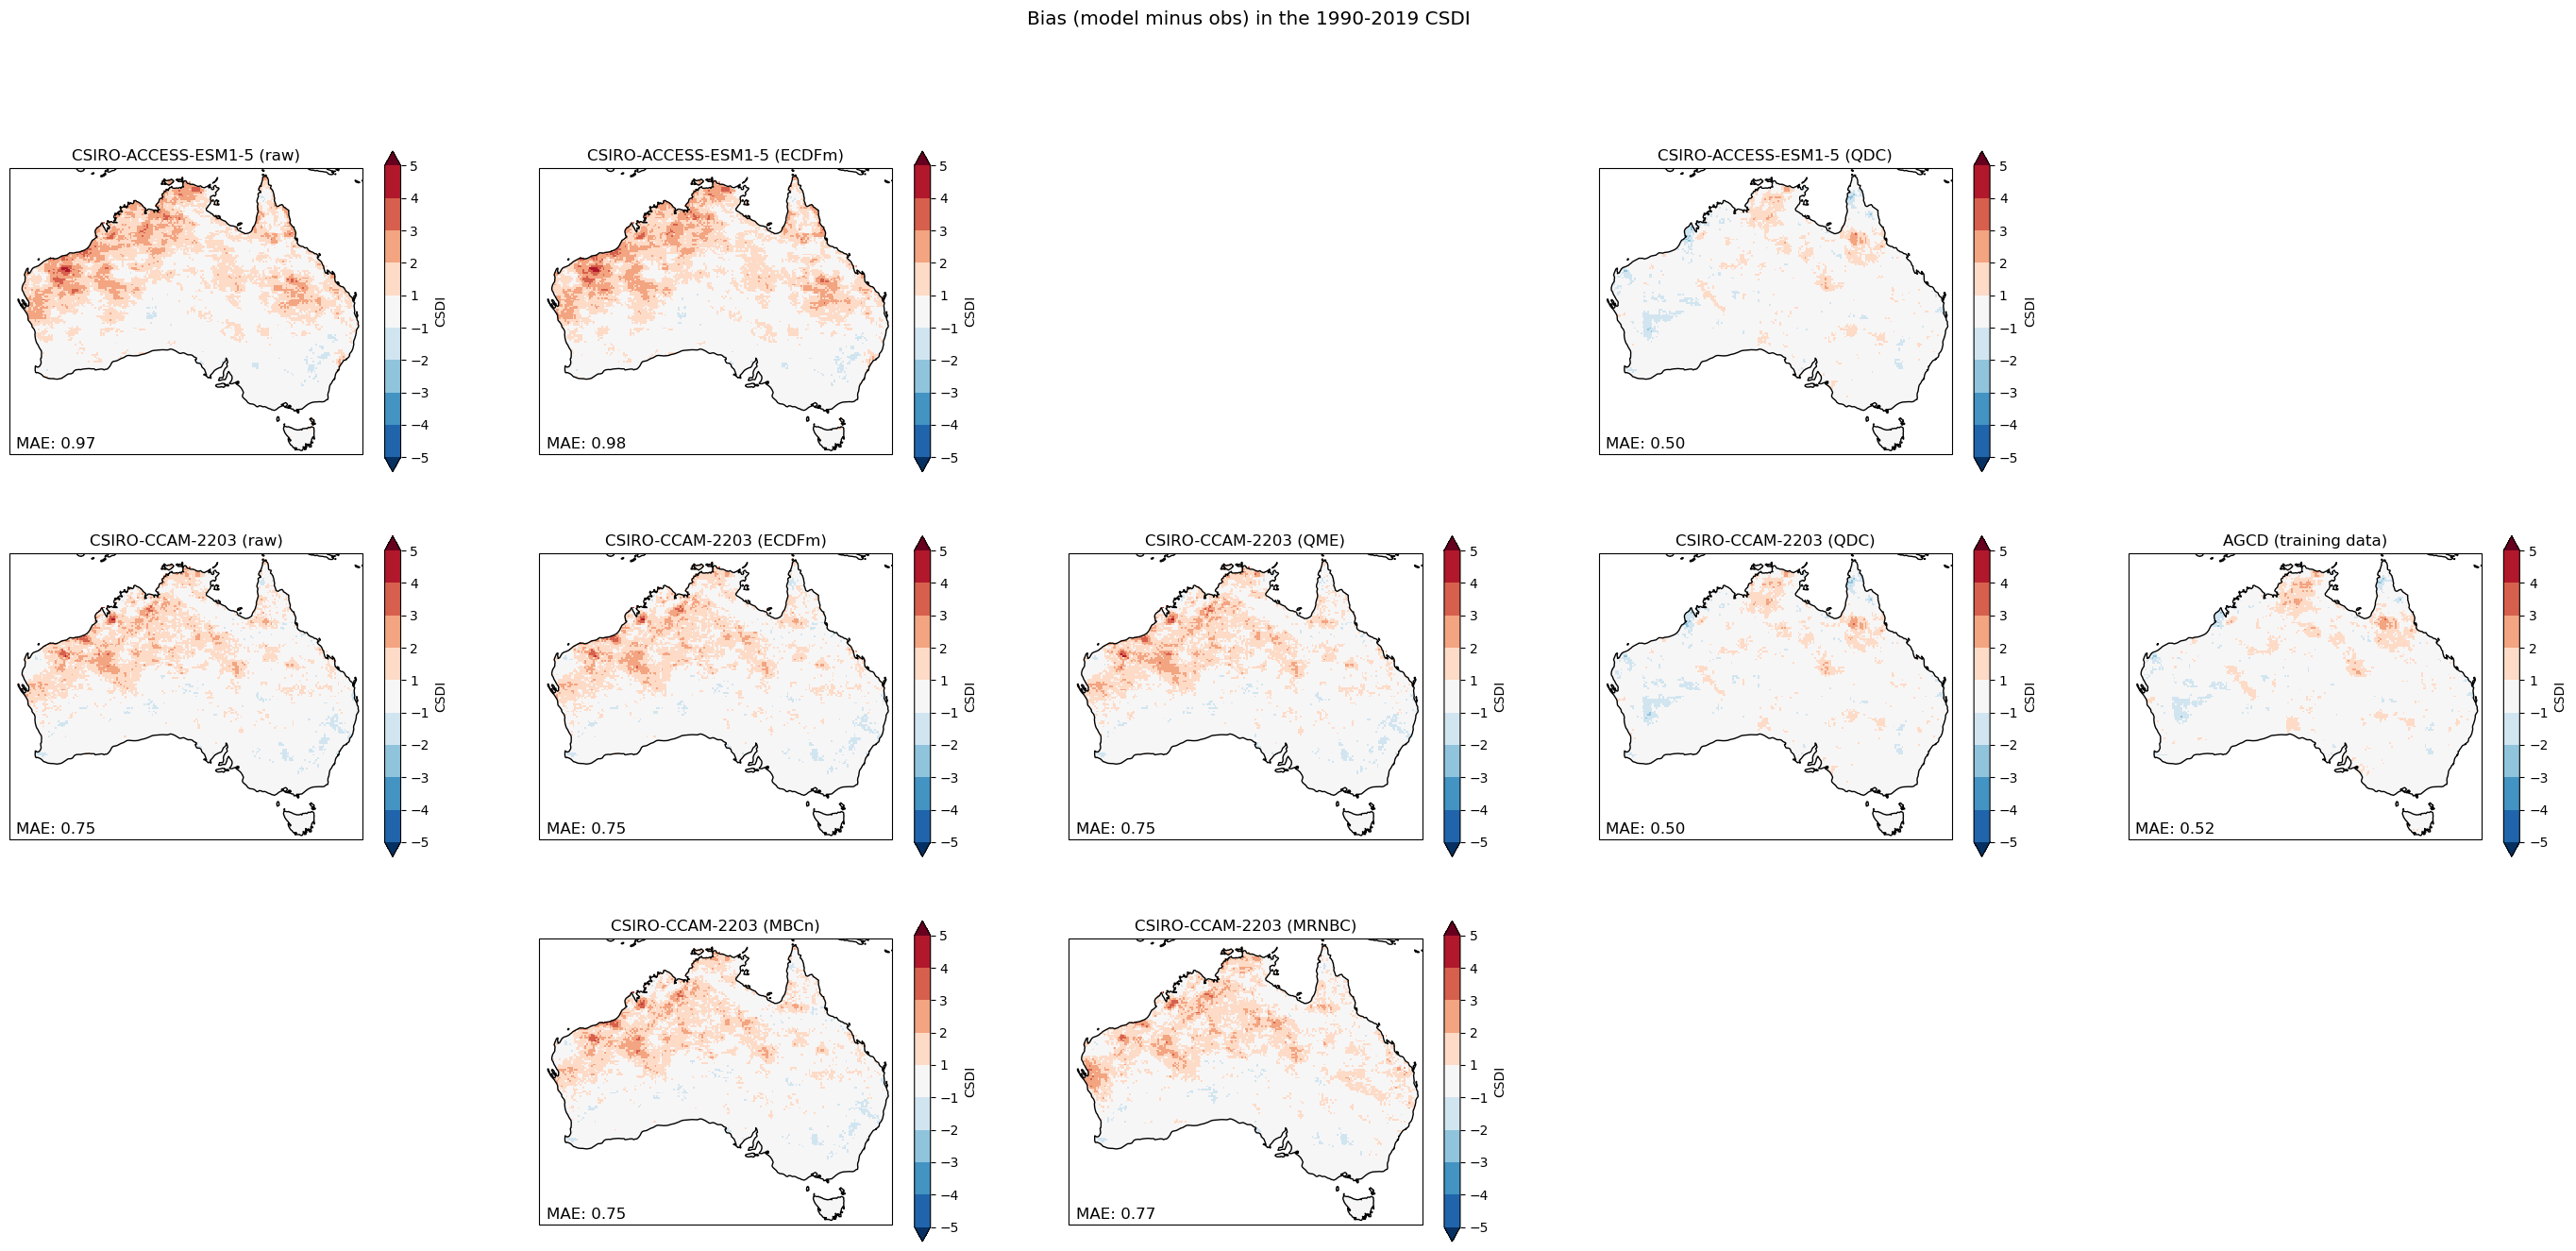

In [34]:
rcm = 'CSIRO-CCAM-2203'
mae_data[task][f'{gcm}_{rcm}'] = plot_comparison(gcm, rcm, task, index, cmap=cmap_bias, levels=levels_bias)

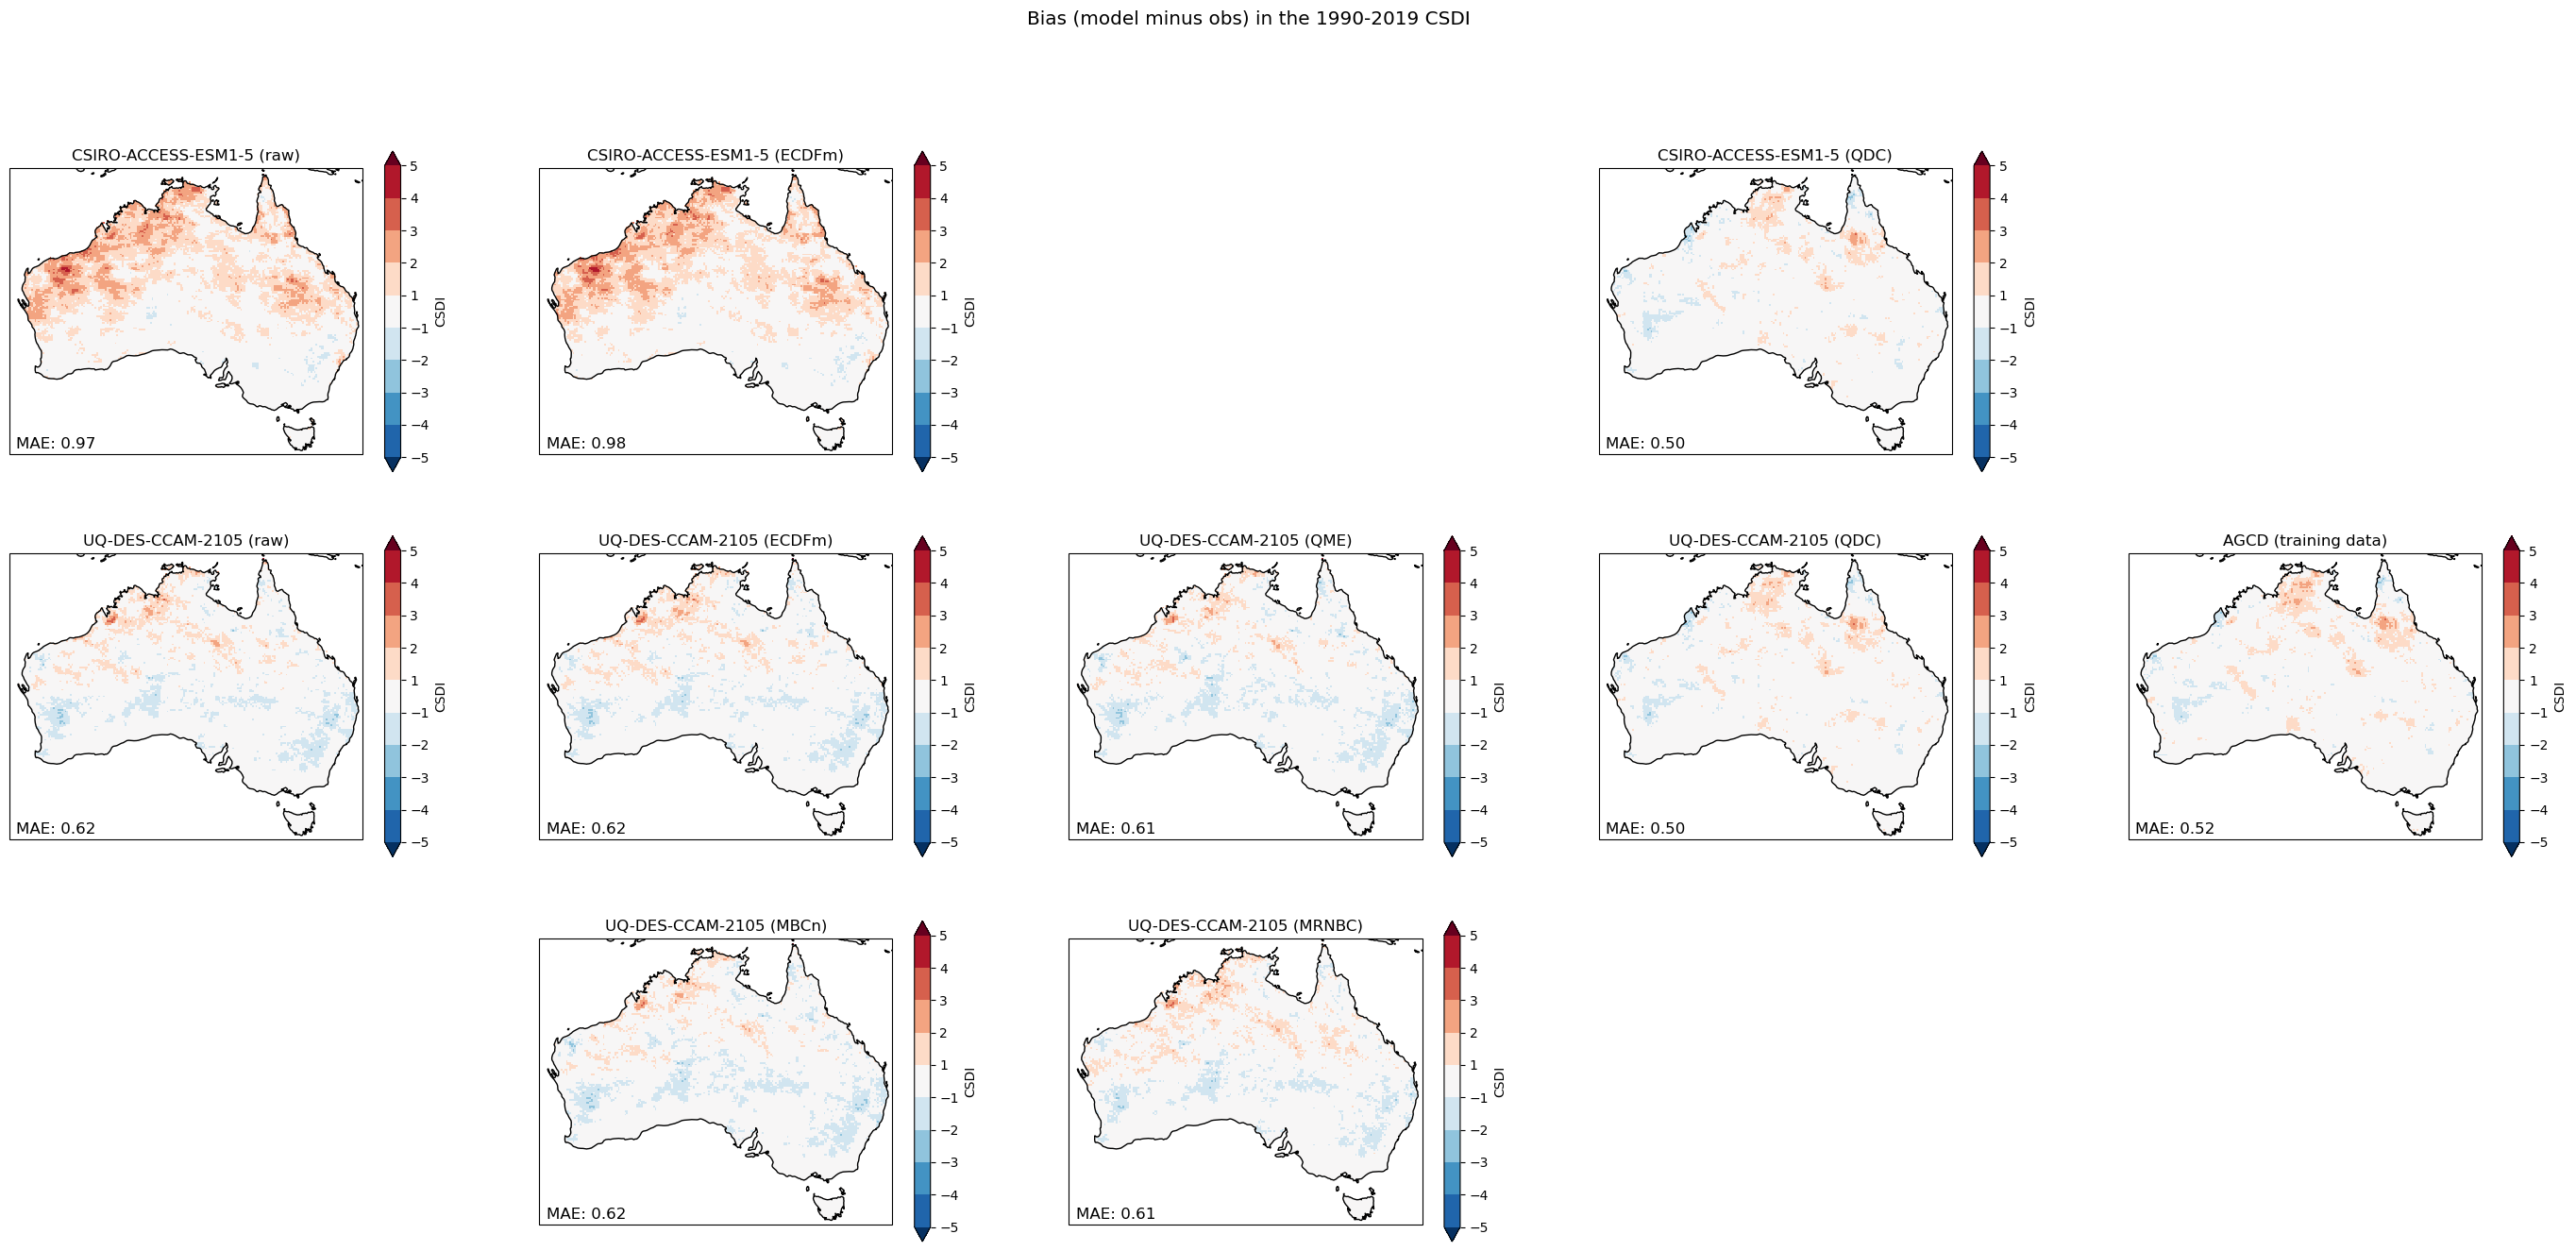

In [35]:
rcm = 'UQ-DES-CCAM-2105'
mae_data[task][f'{gcm}_{rcm}'] = plot_comparison(gcm, rcm, task, index, cmap=cmap_bias, levels=levels_bias)

#### CESM2

In [36]:
gcm = 'NCAR-CESM2'
task = 'xvalidation'
rcm = 'BOM-BARPA-R'

CSDI-values_task-xvalidation_NCAR-CESM2_BOM-BARPA-R.png


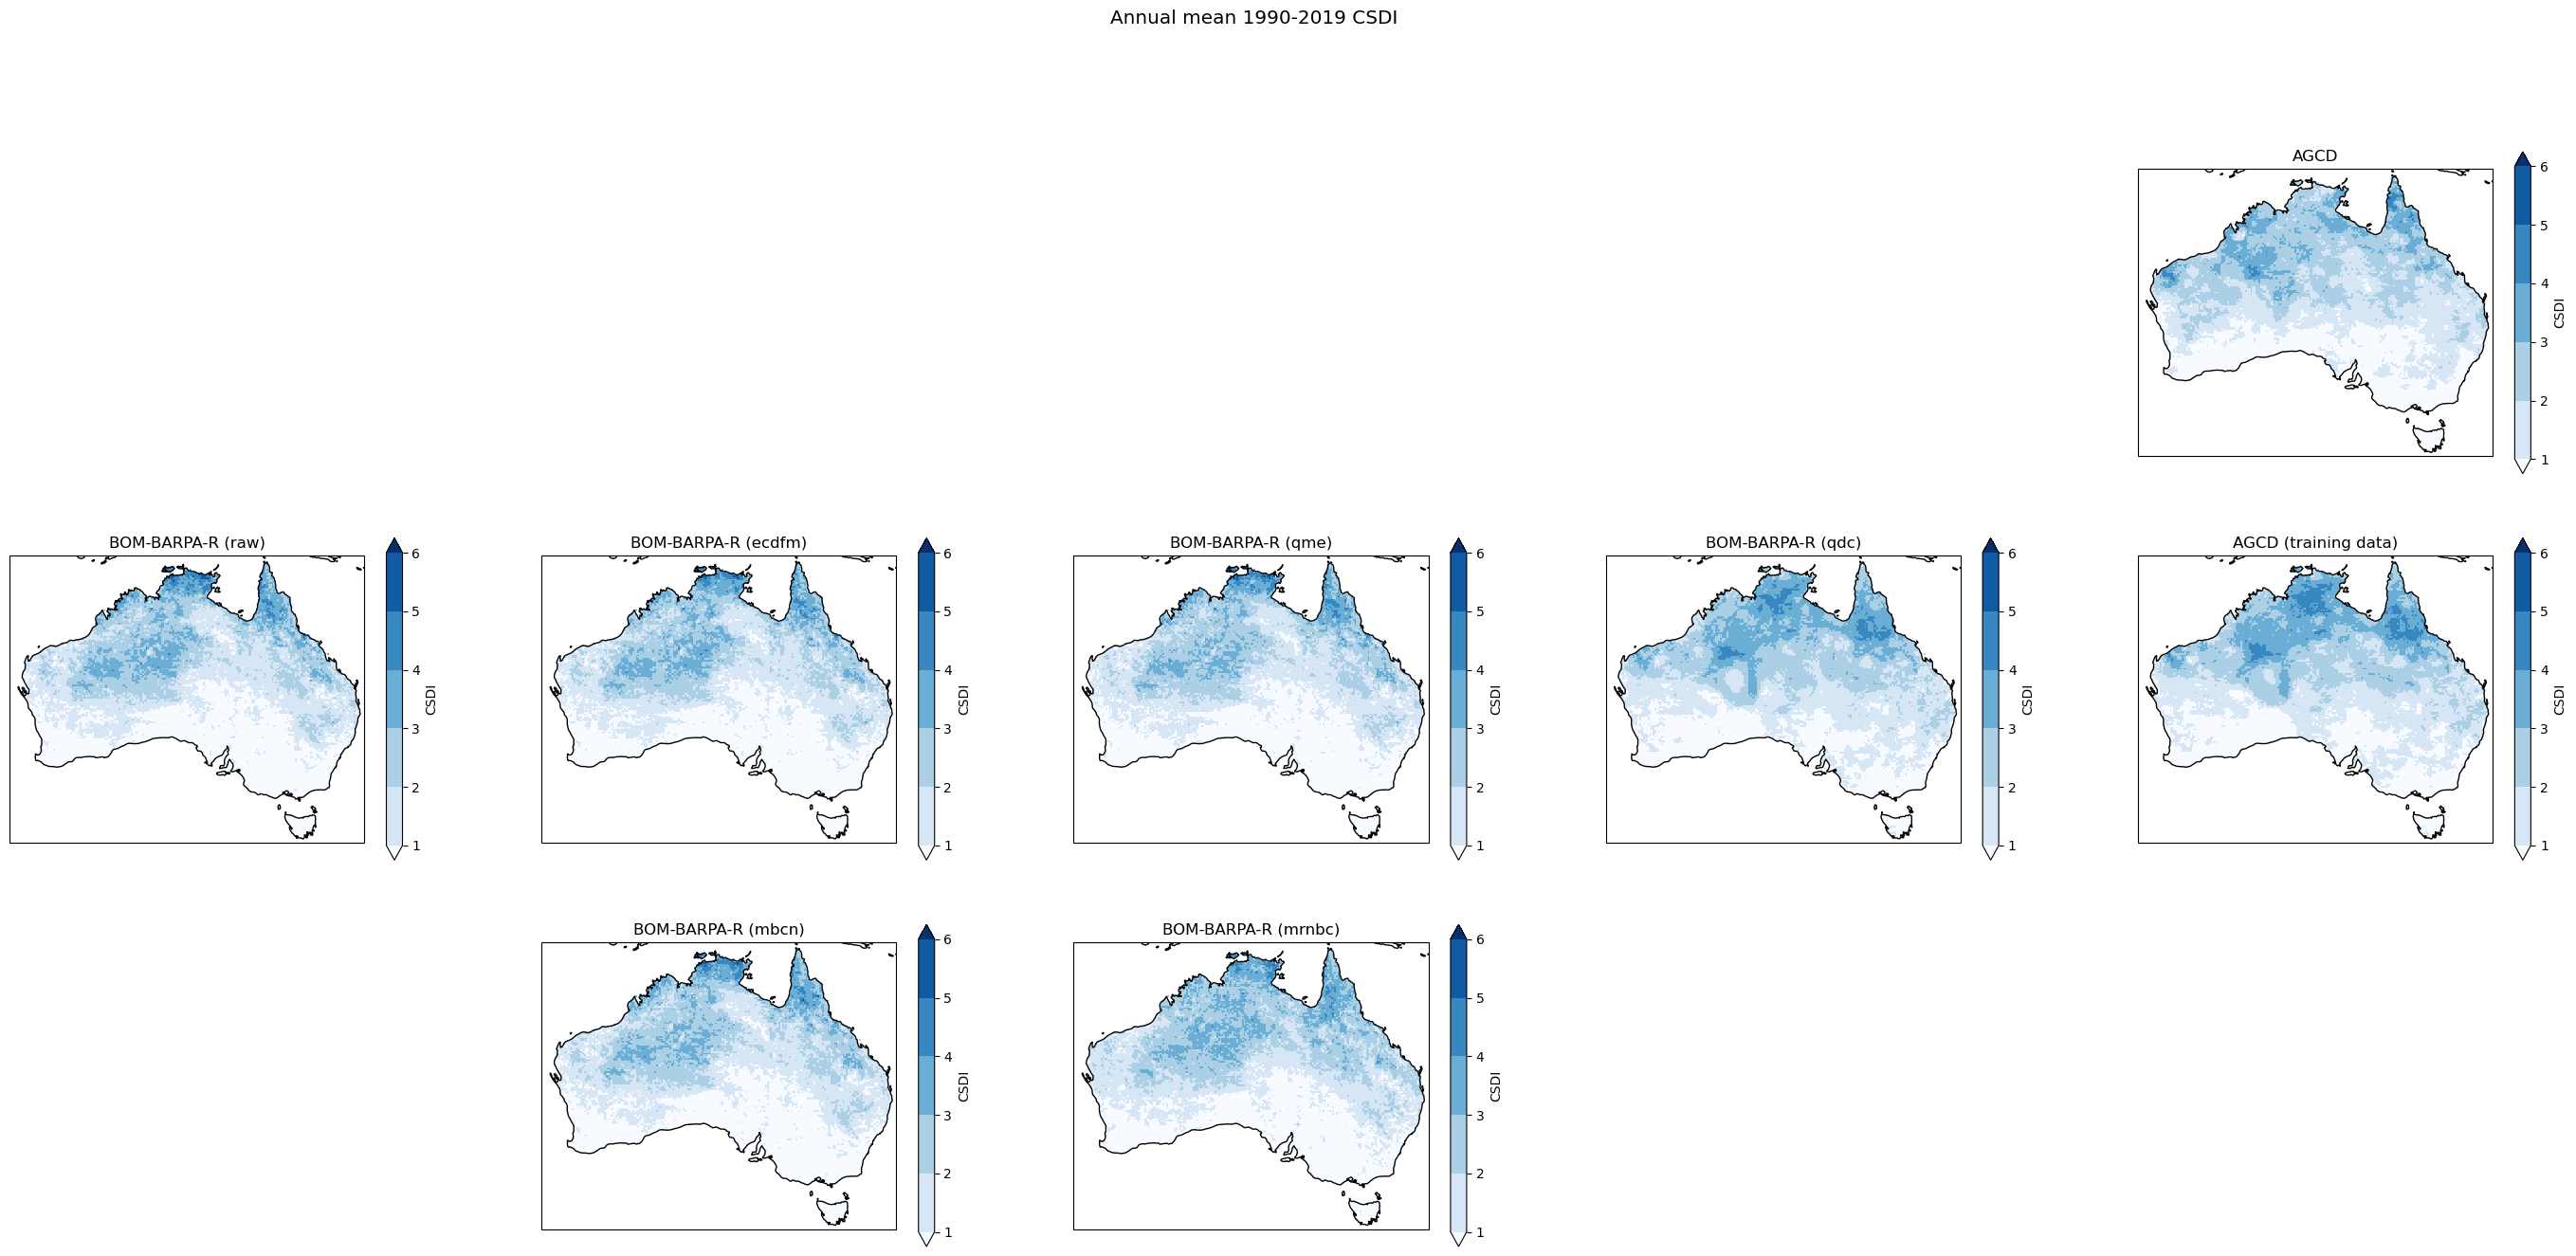

In [37]:
plot_values(gcm, rcm, task, index, cmap=cmap_values, levels=levels_values, outfile=True)

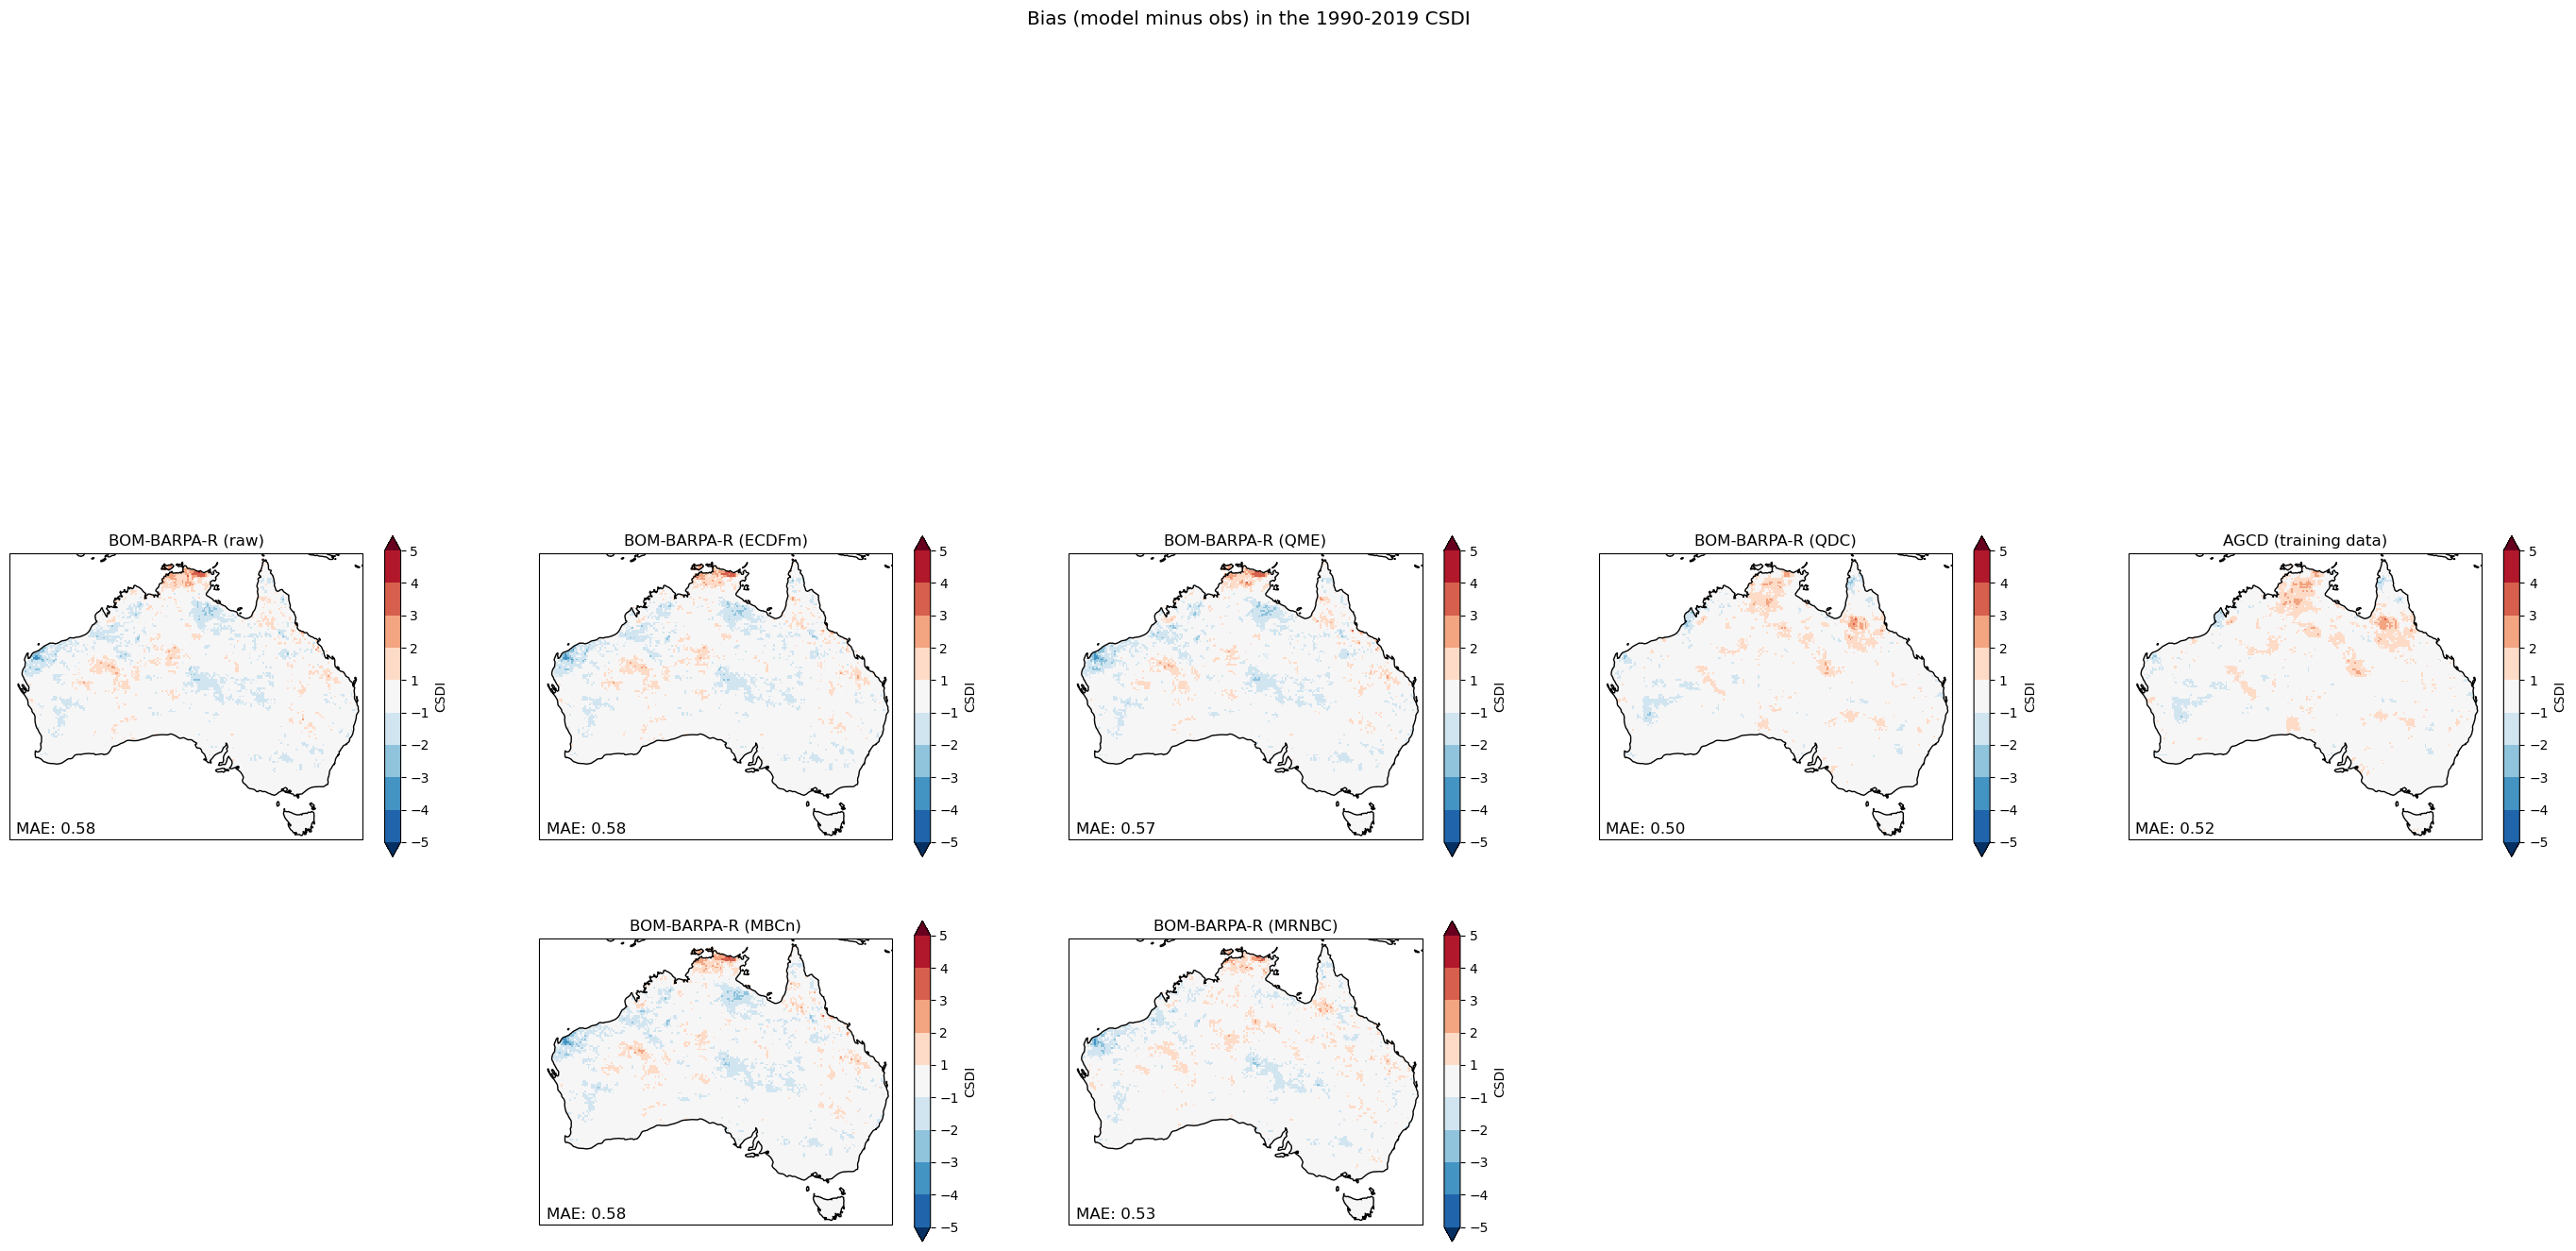

In [38]:
mae_data[task][f'{gcm}_{rcm}'] = plot_comparison(gcm, rcm, task, index, cmap=cmap_bias, levels=levels_bias, outfile=False)

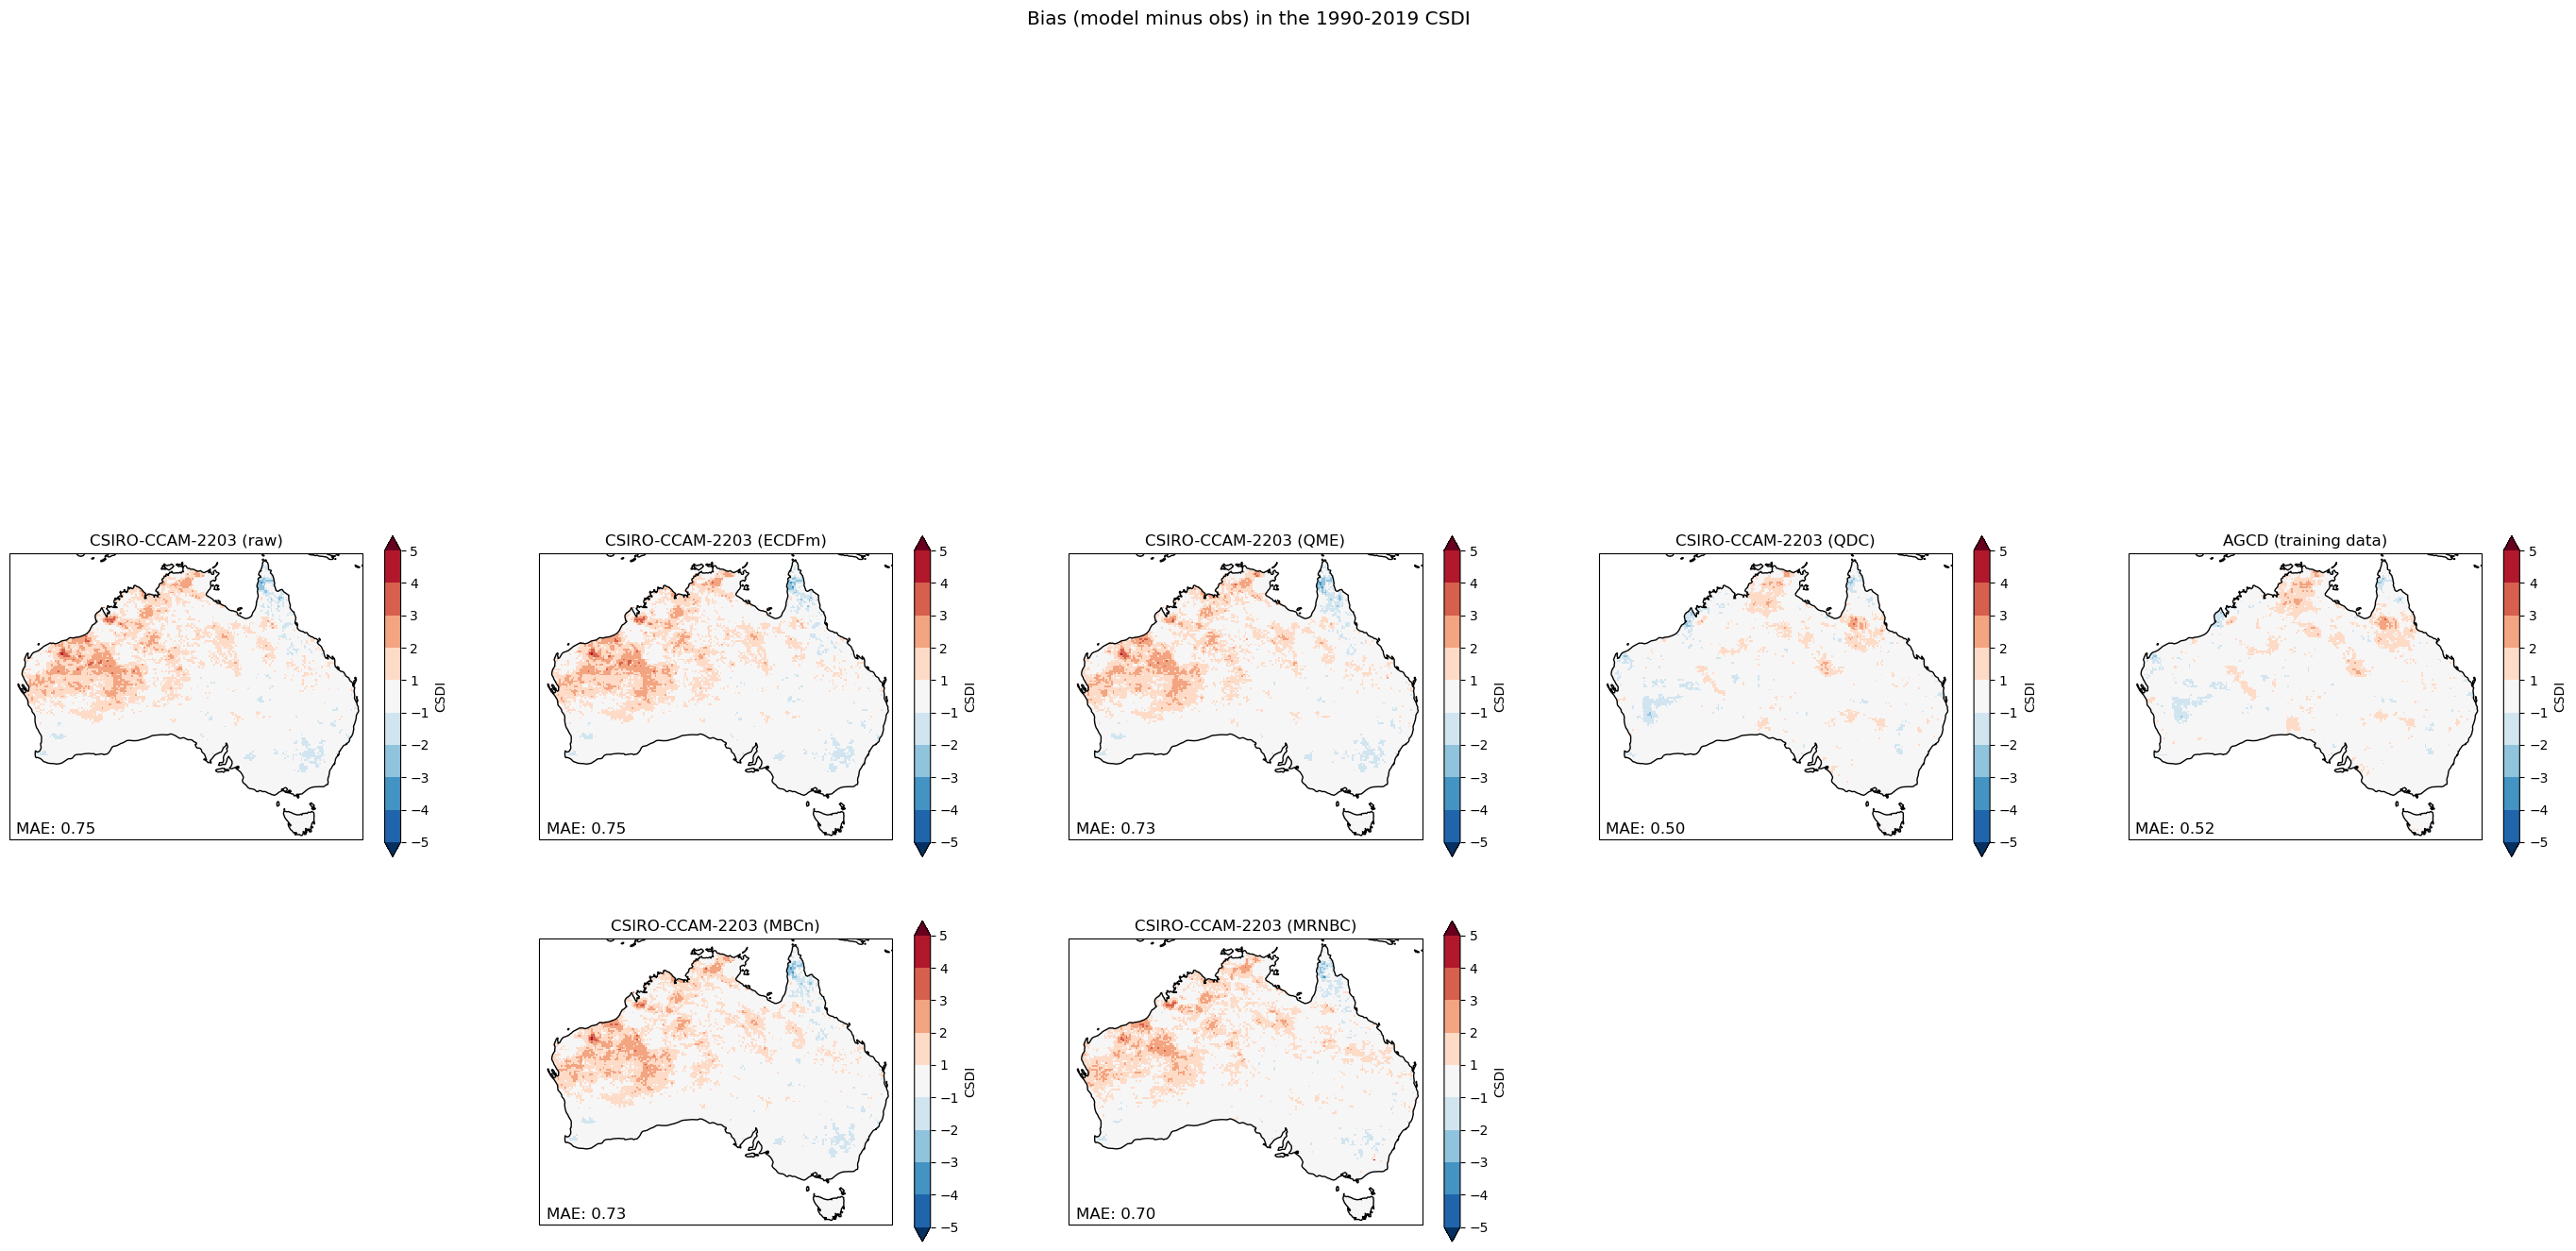

In [39]:
rcm = 'CSIRO-CCAM-2203'
mae_data[task][f'{gcm}_{rcm}'] = plot_comparison(gcm, rcm, task, index, cmap=cmap_bias, levels=levels_bias)

#### EC-Earth3

In [40]:
gcm = 'EC-Earth-Consortium-EC-Earth3'
task = 'xvalidation'
rcm = 'BOM-BARPA-R'

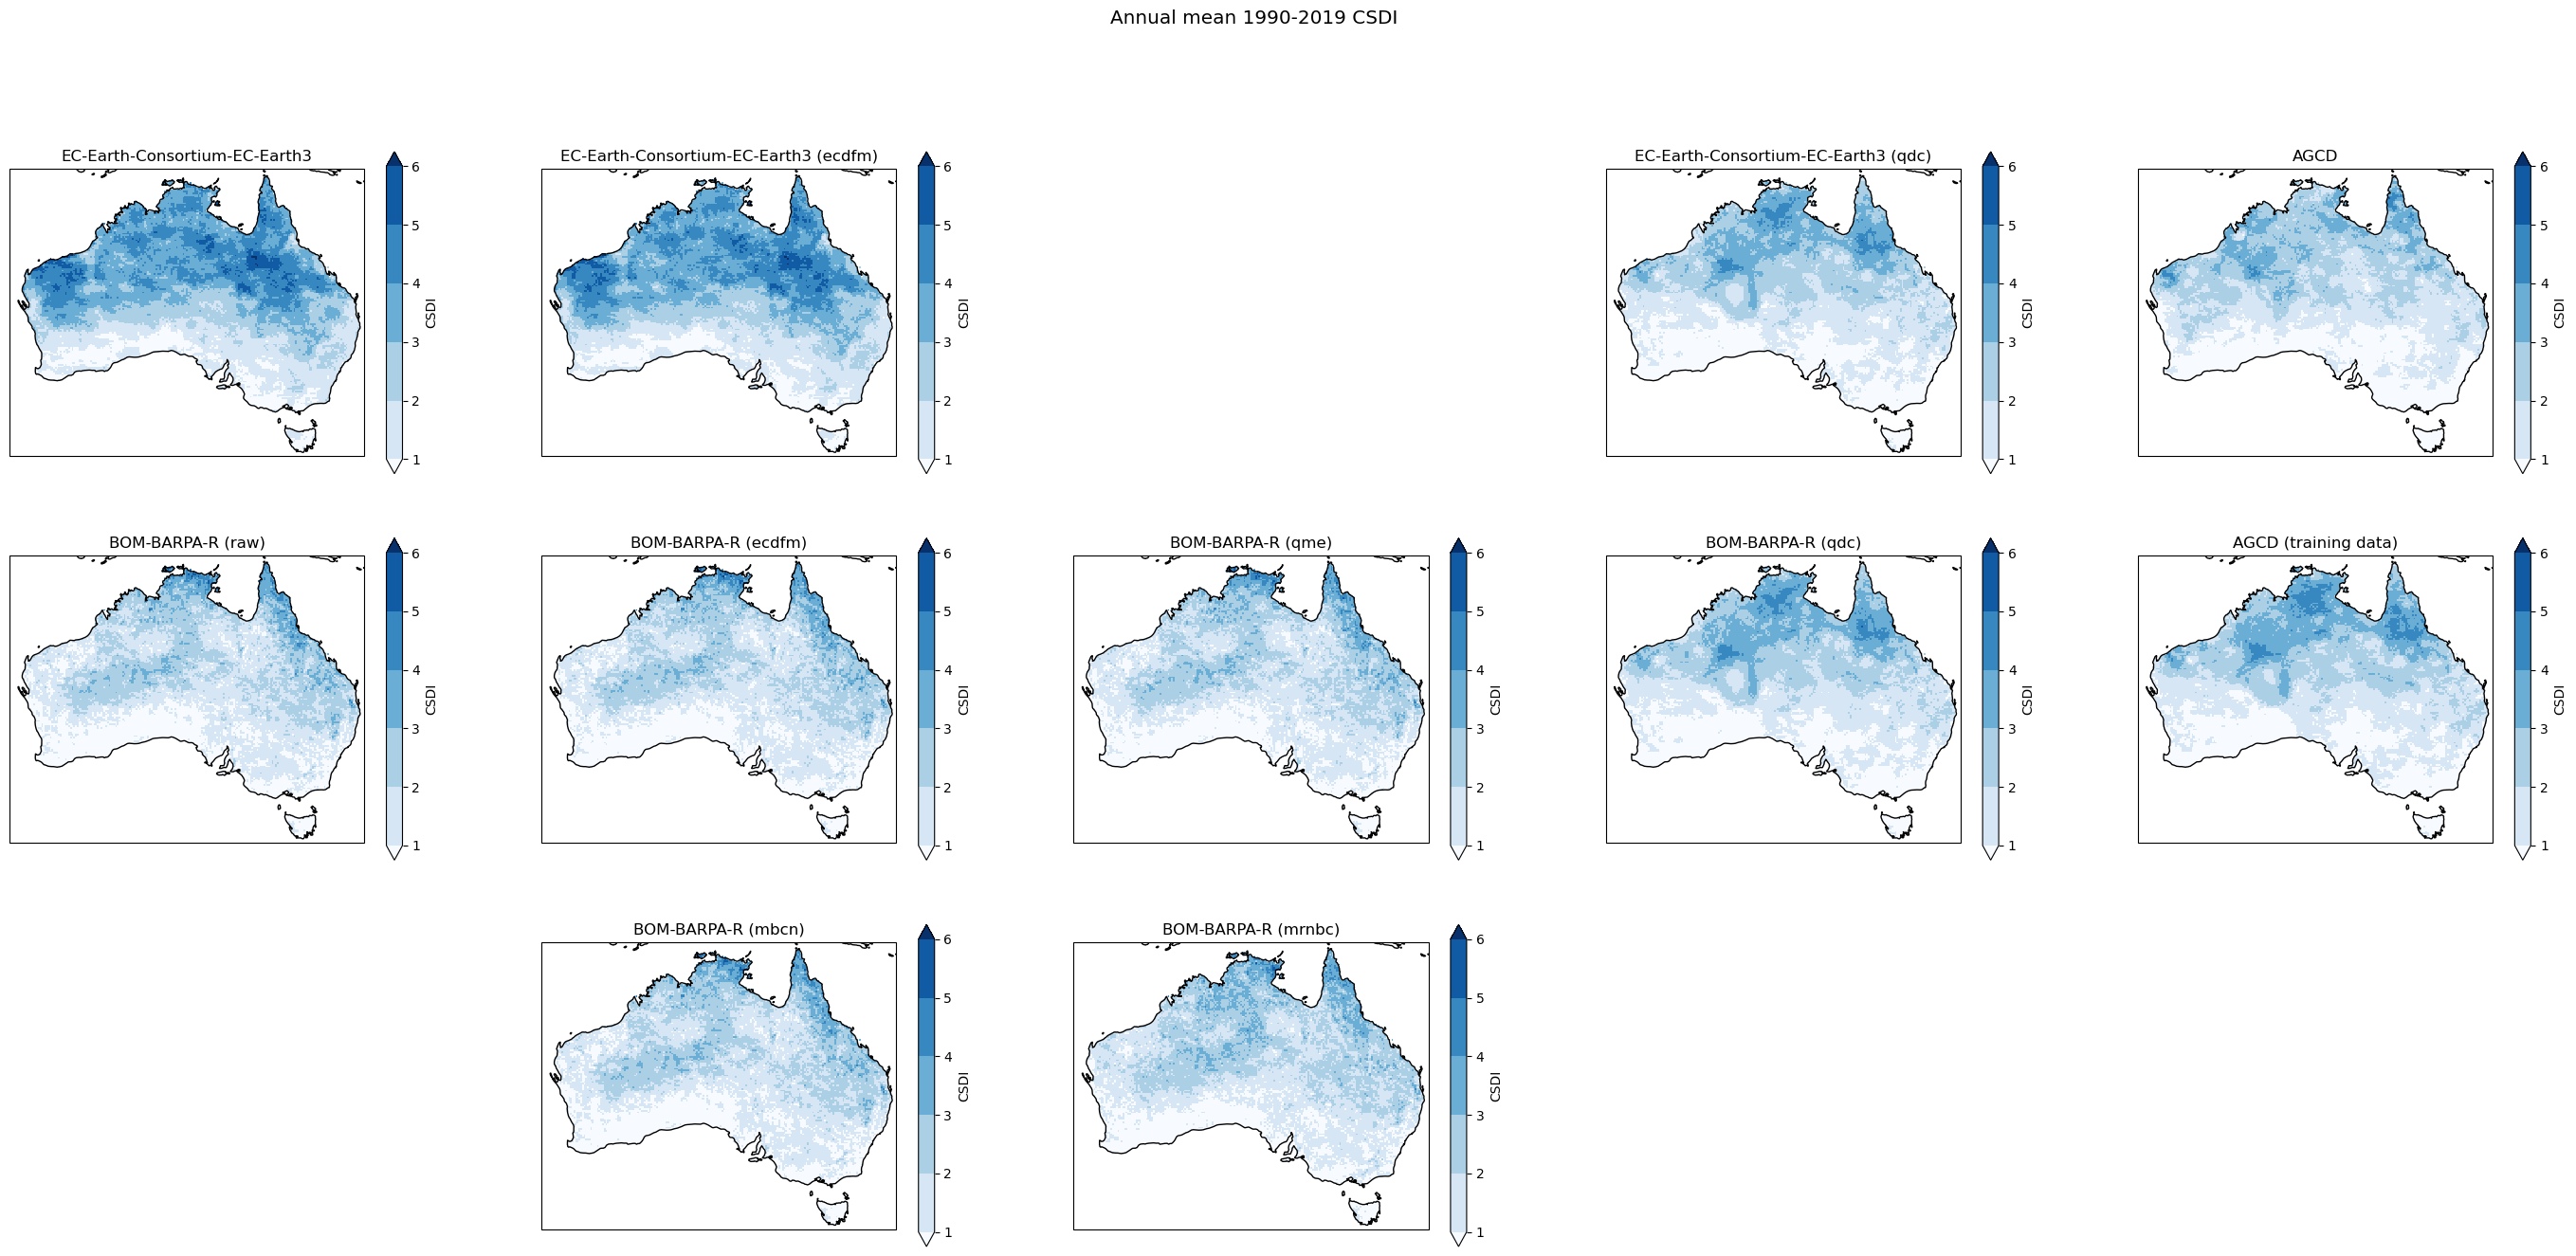

In [41]:
plot_values(gcm, rcm, task, index, cmap=cmap_values, levels=levels_values)

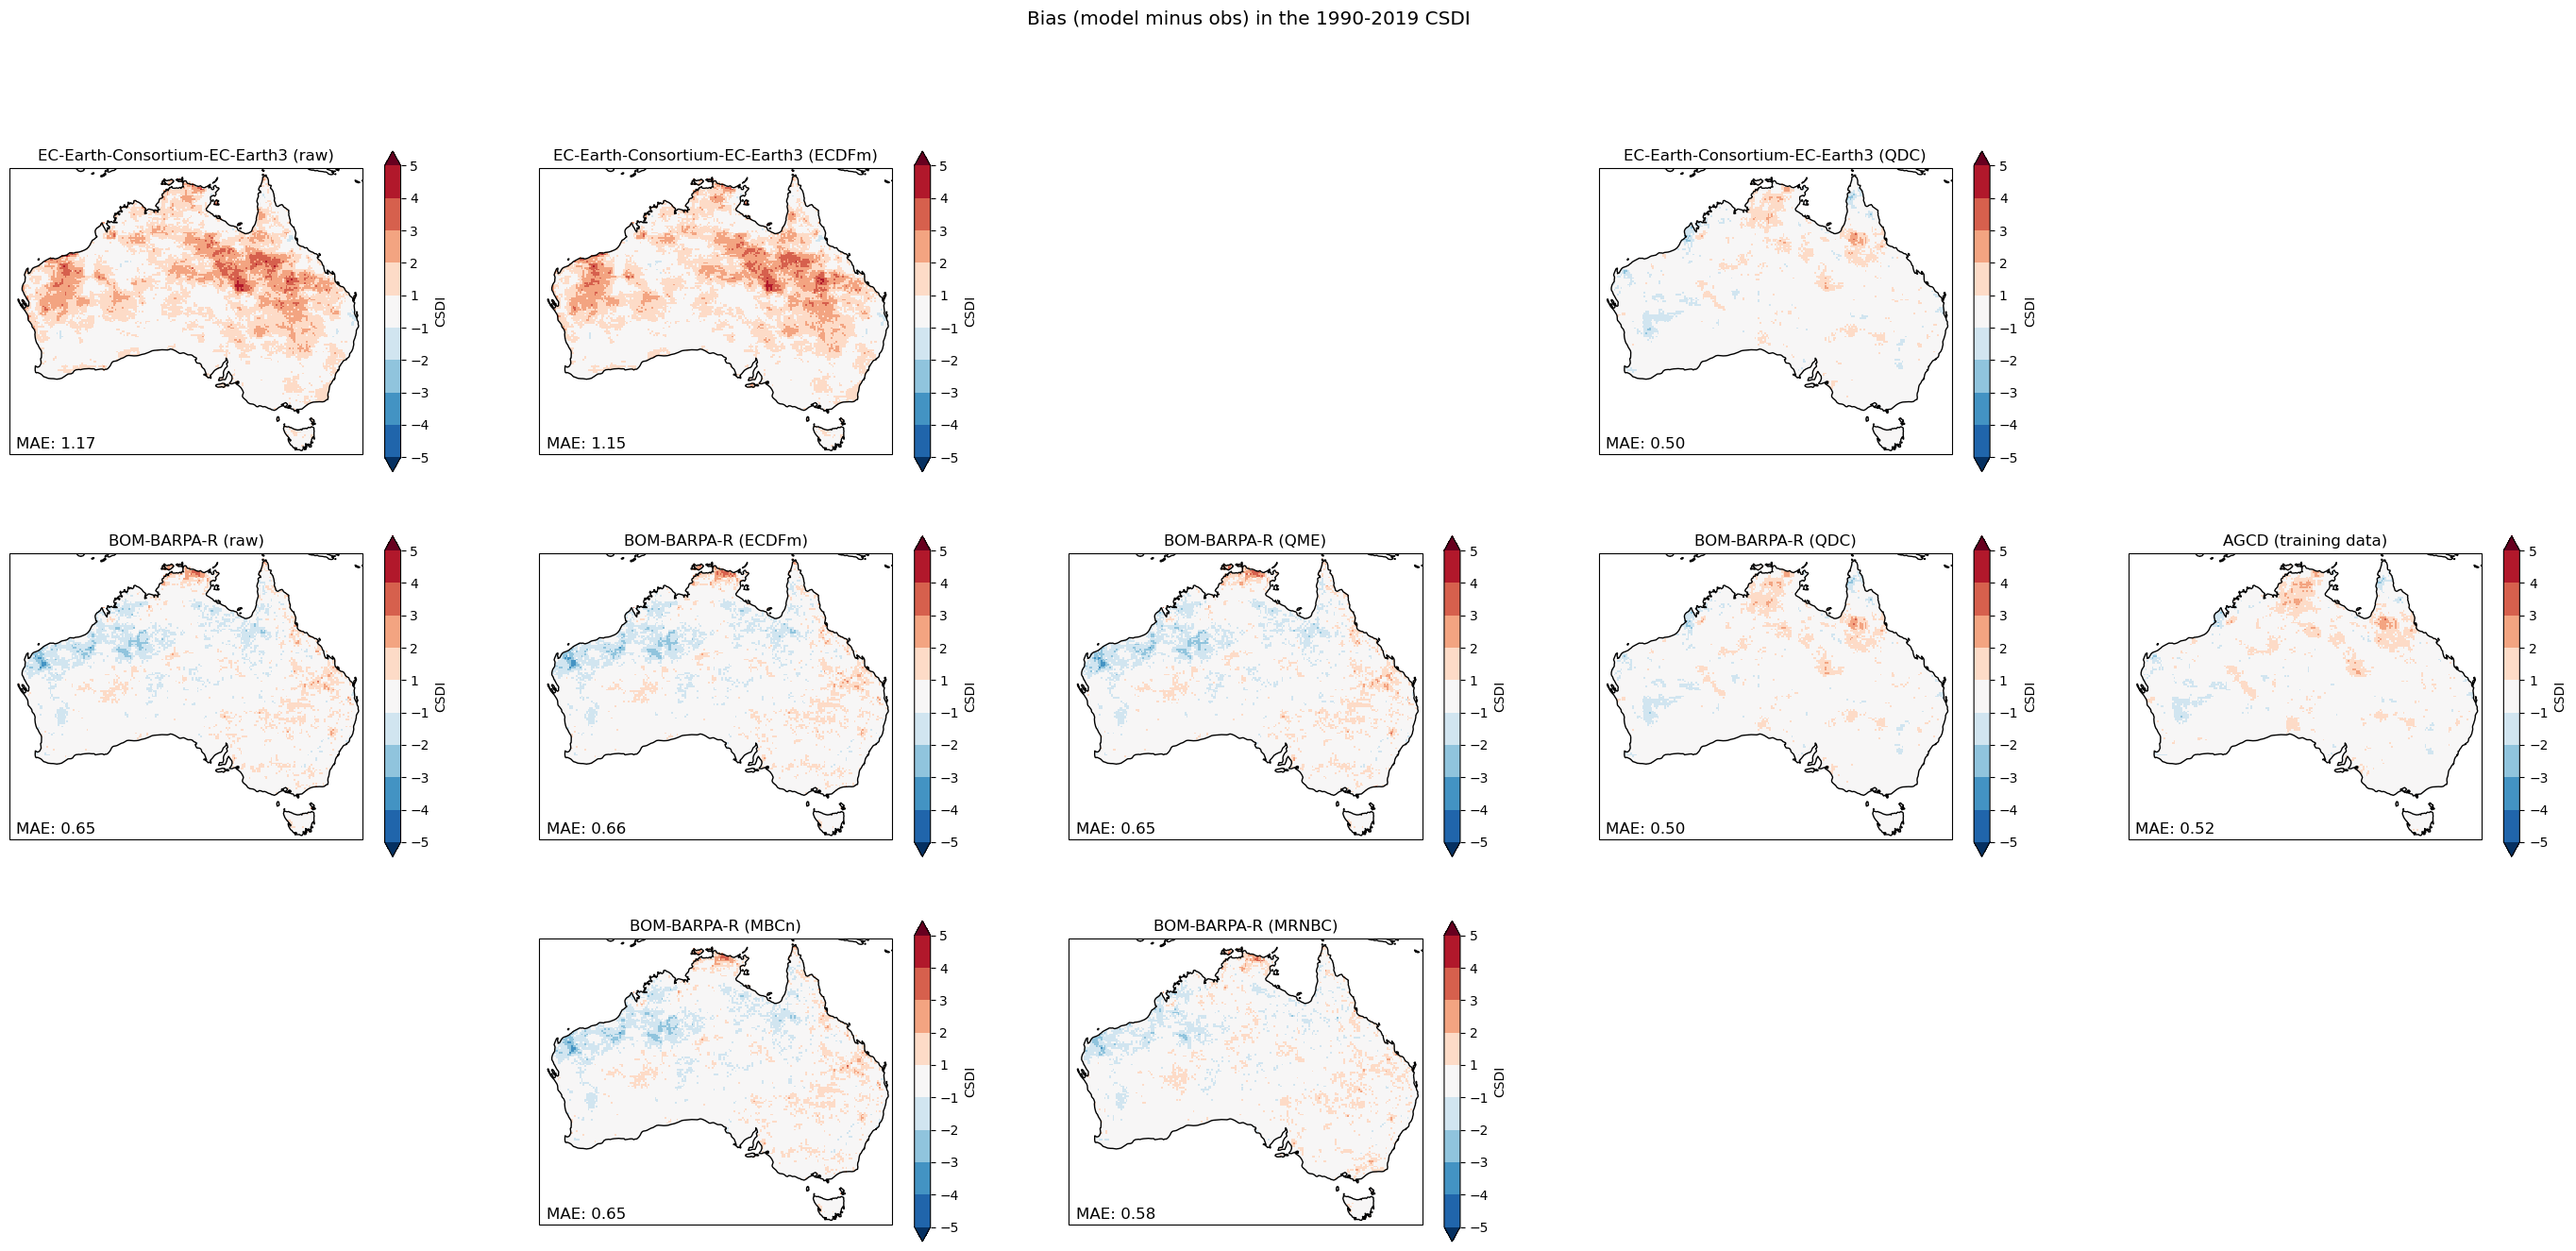

In [42]:
mae_data[task][f'{gcm}_{rcm}'] = plot_comparison(gcm, rcm, task, index, cmap=cmap_bias, levels=levels_bias)

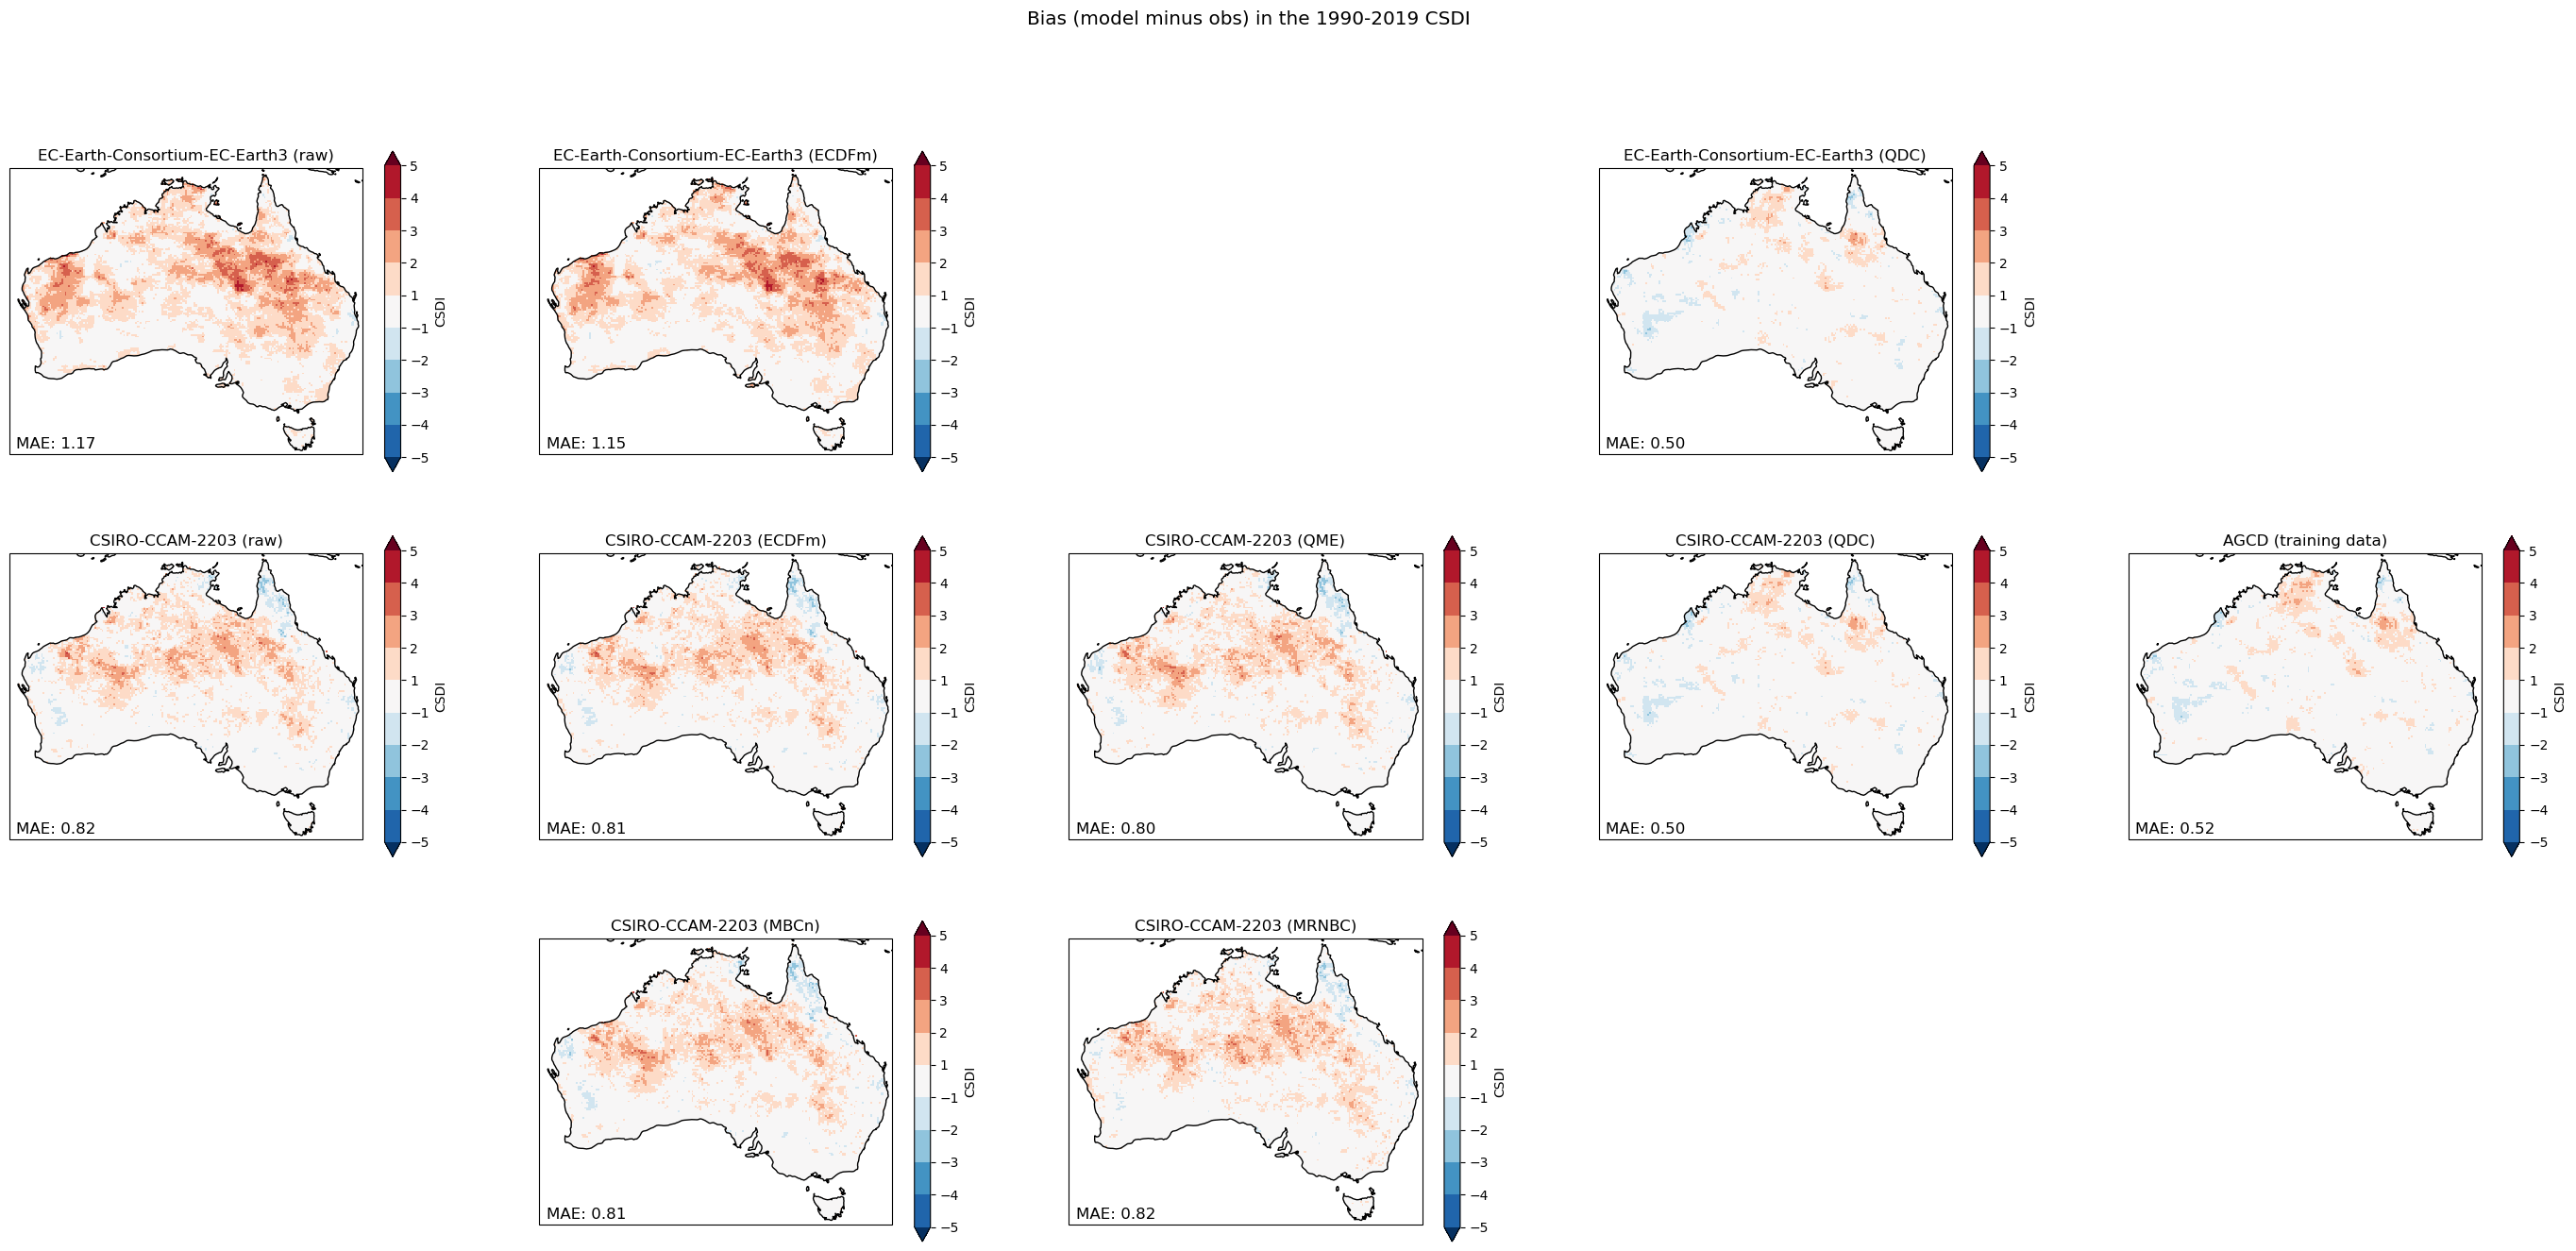

In [43]:
rcm = 'CSIRO-CCAM-2203'
mae_data[task][f'{gcm}_{rcm}'] = plot_comparison(gcm, rcm, task, index, cmap=cmap_bias, levels=levels_bias)

In [44]:
with open(f'{outdir}csdi.yaml', 'w') as outfile:
    yaml.dump(mae_data, outfile)